<a href="https://colab.research.google.com/github/CharlesMaponya/AirLineSentiment-Analysis-Use-case/blob/main/Airline_Sentiment_Use_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline sentiment Use case for Praelexis Assessment

#### Installing the Necessary libraries

In [4]:
!pip install --user pymc
!pip install --user wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Importing the Necessary Libraries

In [74]:
## Operations libraries
import pandas as pd
import numpy as np
import re
import pymc as pm

##Visualization Libraries.
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

##Notebook settings
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
import tqdm as tqdm


import nltk
import string
import re
from PIL import Image

#import contractions
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
import warnings
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer

warnings.filterwarnings(action = 'ignore') 

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
#st.set_option('deprecation.showPyplotGlobalUse', False)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Importing the data

In [6]:
data=pd.read_csv('/content/Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Data quality Analysis 

In [7]:
class DataQuality:
    def __init__(self,data):
        self.data = data
    
    def completeness(self):
        df = self.data.copy()
        score = 100 - df.isnull().sum().sum() / (df.size) * 100
        score = round(score)
        if score <= 50:
            color = 'darkred'
            backrgound = 'red'
        elif score in range(50, 80):
            color = 'orange'
            backrgound = 'orangered'
        elif score >= 80:
            color = 'rgb(112,130,56)'
            backrgound = 'darkseagreen'
        try:
            import matplotlib.pyplot as plt
            import plotly.graph_objects as go
        except:
            print("You need matplotlib & plotly to continue. Install now?(y/n)")
            response = input()
            if response == 'y':
                !pip install --user plotly matplotlib
            else:
                print("please install matplotlib & plotly libraries To continue")
        
        fig = go.Figure(
            go.Indicator(mode="gauge+number",
                         value=score,
                         domain={
                             'x': [0, 1],
                             'y': [0, 1]
                         },
                         title={'text': "Data Completeness Score"},
                         gauge={
                             'bar': {
                                 'color': color
                             },
                             'axis': {
                                 'range': [None, 100],
                                 'tickwidth': 1,
                                 'tickcolor': "darkblue"
                             },
                             'steps': [{
                                 'range': [0, 100]
                             }, {
                                 'range': [0, 100],
                                 'color': backrgound
                             }]
                         }))
        return fig
    
    def shape(self):
        df = self.data
        return df.shape
    
    def outliers_analysis(self):
        """
        Returns:
        ---------
        IQR: Pandas dataFrame
            With values inside the Interquartile Range
        """
        df = self.data
        IQR = df.quantile(0.75) - df.quantile(0.25)
        plt.subplots(figsize=(15, 7))
        plt.title("Outliers Per feature")

        plot =IQR.sort_values(ascending=False).plot(kind='bar')
        plt.xlabel('Feature')
        plt.ylabel("Count of Outliers")
        for p in plot.patches:
            if p.get_height() == 0:
                pass
            else:
                plot.annotate(format(p.get_height(), '.1f'),(p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center',
                              va='center',
                              color='white',
                              xytext=(0, -12),
                              rotation=90,
                              textcoords='offset points')
    
    
    def info(self):
        df = self.data
        return df.info()
    
    def Missing_Data(self):
        df = self.data
        missing = df.isnull().sum() / df.shape[0] * 100
        plt.subplots(figsize=(15, 7))
        plt.title("Percentage of Missing Data")
        plot = missing.sort_values(ascending=False).plot(kind='bar')
        plt.xlabel('Feature')
        plt.ylabel("% of Missing Data")
        for p in plot.patches:
            if p.get_height() == 0:
                pass
            else:
                plot.annotate(format(p.get_height(), '.1f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center',
                              va='center',
                              color='white',
                              xytext=(0, -12),
                              rotation=90,
                              textcoords='offset points')
    
    def turkey(self, col):
        df = self.data
        if df[col].dtype == 'object':
            return np.NaN
        else:
            Q1 = np.quantile(df[col],0.25)
            Q3 = np.quantile(df[col],0.75)
            IQR = Q3 - Q1
            floor = Q1 - 1.5*IQR
            ceil = Q3 + 1.5*IQR
            num_outliers= ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum().astype('int64')
            return num_outliers
        
    
    def assessment(self):
        df = self.data
        sub = df.describe(include='all',datetime_is_numeric=True).T.reset_index()
        sub.rename(columns={'index':'Feature'},inplace=True)
        sub['Data Type'] = sub['Feature'].apply(lambda x: df[x].dtype)
        sub['Missing Values']= sub['Feature'].apply(lambda x: df[x].isnull().sum())
        sub['Missing Percent']= sub['Feature'].apply(lambda x: round(df[x].isnull().sum()/len(df)*100,2))
        sub['Duplicates'] = sub['Feature'].apply(lambda x: df[x].duplicated().sum())
        sub['Outliers'] = sub['Feature'].apply(lambda x: self.turkey(x)) 
        sub.rename(columns={
            'count':'Records','unique':'Unique',
            'top':'Common Value','freq':'Frequency',
            'mean':'Mean','std':'Std Dev',
            'min':'Minimum','25%':'25th Quartile',
            '50%':'Median','75%':'75th Quartile',
            'max':'Maximum','top':'Common Value'
        },inplace=True)
        
        sub.replace(np.NaN,'*', inplace=True)
        #sub.sort_values(by= ['Unique'], ascending= False)
        sub = sub[['Feature','Data Type','Records','Unique','Common Value','Frequency','Duplicates','Outliers',
                  'Missing Values','Missing Percent','Mean','Std Dev','Minimum','25th Quartile',
                  'Median', '75th Quartile', 'Maximum']]
        name= "*"
        print(f" Note that {name} indicate that no calculation record can be found for that field")
        return sub

In [8]:
report = DataQuality(data)

#### Data completeness

In [9]:
report.completeness()

the data is only 72% complete meaning that there's 38% of the total data points that are still missing

#### Missing data analysis

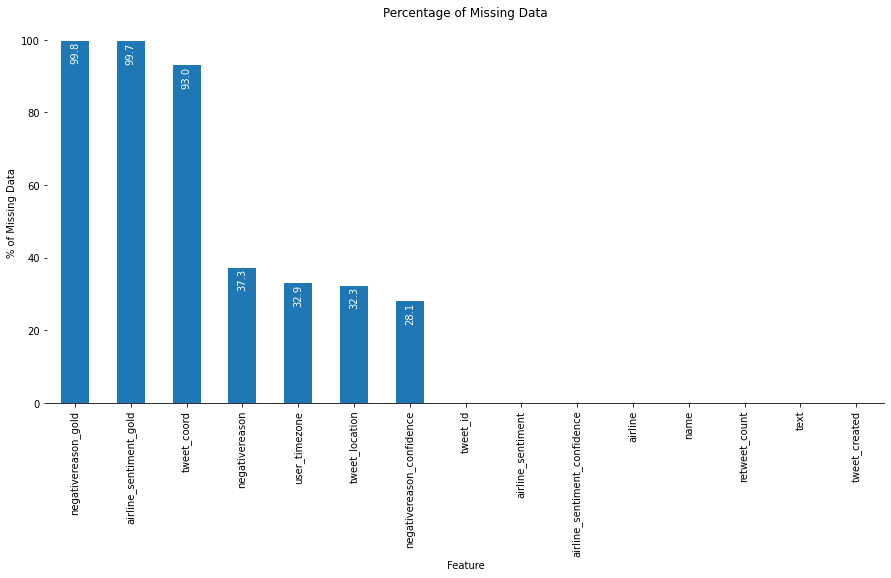

In [10]:
report.Missing_Data()

 3 features, namely airline_sentiment_gold,negativereason_gold & tweet_coord have more than 93% missing data which cannot be imputed or interpolated hence we gain no insights from these features

#### Checking the data shape

In [11]:
report.shape()

(14640, 15)

#### Data quality assessment report

In [12]:
report.assessment()

 Note that * indicate that no calculation record can be found for that field


,Feature,Data Type,Records,Unique,Common Value,Frequency,Duplicates,Outliers,Missing Values,Missing Percent,Mean,Std Dev,Minimum,25th Quartile,Median,75th Quartile,Maximum
0,tweet_id,int64,14640.0,*,*,*,155,0.0,0,0.00,569218351767499200.0,779111158481835.875,567588278875213824.0,568559178101439488.0,569477857923110912.0,569890473289000960.0,570310600460525568.0
1,airline_sentiment,object,14640.0,3,negative,9178,14637,*,0,0.00,*,*,*,*,*,*,*
2,airline_sentiment_confidence,float64,14640.0,*,*,*,13617,0.0,0,0.00,0.900169,0.16283,0.335,0.6923,1.0,1.0,1.0
3,negativereason,object,9178.0,10,Customer Service Issue,2910,14629,*,5462,37.31,*,*,*,*,*,*,*
4,negativereason_confidence,float64,10522.0,*,*,*,13229,0.0,4118,28.13,0.638298,0.33044,0.0,0.3606,0.6706,1.0,1.0
5,airline,object,14640.0,6,United,3822,14634,*,0,0.00,*,*,*,*,*,*,*
6,airline_sentiment_gold,object,40.0,3,negative,32,14636,*,14600,99.73,*,*,*,*,*,*,*
7,name,object,14640.0,7701,JetBlueNews,63,6939,*,0,0.00,*,*,*,*,*,*,*
8,negativereason_gold,object,32.0,13,Customer Service Issue,12,14626,*,14608,99.78,*,*,*,*,*,*,*
9,retweet_count,int64,14640.0,*,*,*,14622,767.0,0,0.00,0.08265,0.745778,0.0,0.0,0.0,0.0,44.0


##### Dropping the features which we gain no insights from

In [13]:
data.drop(['airline_sentiment_gold','negativereason_gold','tweet_coord'],axis=1,inplace=True)

#### Rechecking data completeness

In [14]:
rep=DataQuality(data)
rep.completeness()

The data completeness has improved from 72% to 89% just by removing only 3 features from the data set

#### Missing data analysis re check

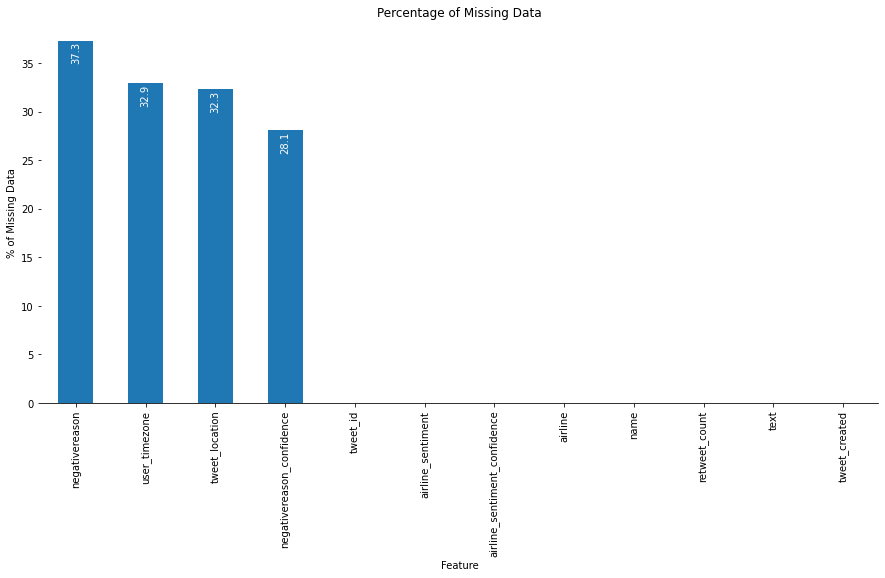

In [15]:
rep.Missing_Data()

now only 4 feature have missing data above 25% which would account for the overall 11% data missing of the total data points available

#### Outlier Analysis

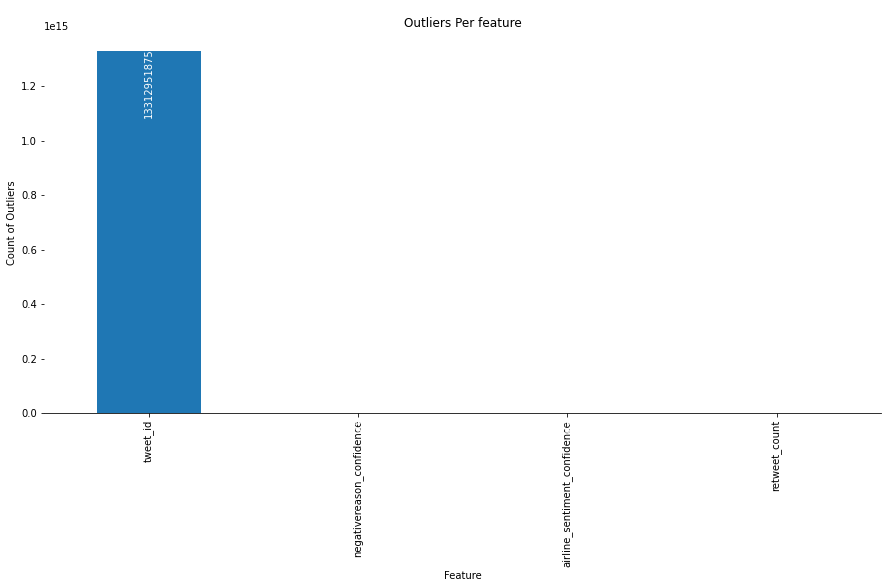

In [16]:
rep.outliers_analysis()

there's no feature with any outliers

#### Data quality assessment report  re check

In [17]:
rep.assessment()

 Note that * indicate that no calculation record can be found for that field


,Feature,Data Type,Records,Unique,Common Value,Frequency,Duplicates,Outliers,Missing Values,Missing Percent,Mean,Std Dev,Minimum,25th Quartile,Median,75th Quartile,Maximum
0,tweet_id,int64,14640.0,*,*,*,155,0.0,0,0.00,569218351767499200.0,779111158481835.875,567588278875213824.0,568559178101439488.0,569477857923110912.0,569890473289000960.0,570310600460525568.0
1,airline_sentiment,object,14640.0,3,negative,9178,14637,*,0,0.00,*,*,*,*,*,*,*
2,airline_sentiment_confidence,float64,14640.0,*,*,*,13617,0.0,0,0.00,0.900169,0.16283,0.335,0.6923,1.0,1.0,1.0
3,negativereason,object,9178.0,10,Customer Service Issue,2910,14629,*,5462,37.31,*,*,*,*,*,*,*
4,negativereason_confidence,float64,10522.0,*,*,*,13229,0.0,4118,28.13,0.638298,0.33044,0.0,0.3606,0.6706,1.0,1.0
5,airline,object,14640.0,6,United,3822,14634,*,0,0.00,*,*,*,*,*,*,*
6,name,object,14640.0,7701,JetBlueNews,63,6939,*,0,0.00,*,*,*,*,*,*,*
7,retweet_count,int64,14640.0,*,*,*,14622,767.0,0,0.00,0.08265,0.745778,0.0,0.0,0.0,0.0,44.0
8,text,object,14640.0,14427,@united thanks,6,213,*,0,0.00,*,*,*,*,*,*,*
9,tweet_created,object,14640.0,14247,2015-02-24 09:54:34 -0800,5,393,*,0,0.00,*,*,*,*,*,*,*


## Exploratory Data analysis

#### Airline sentiment by Class

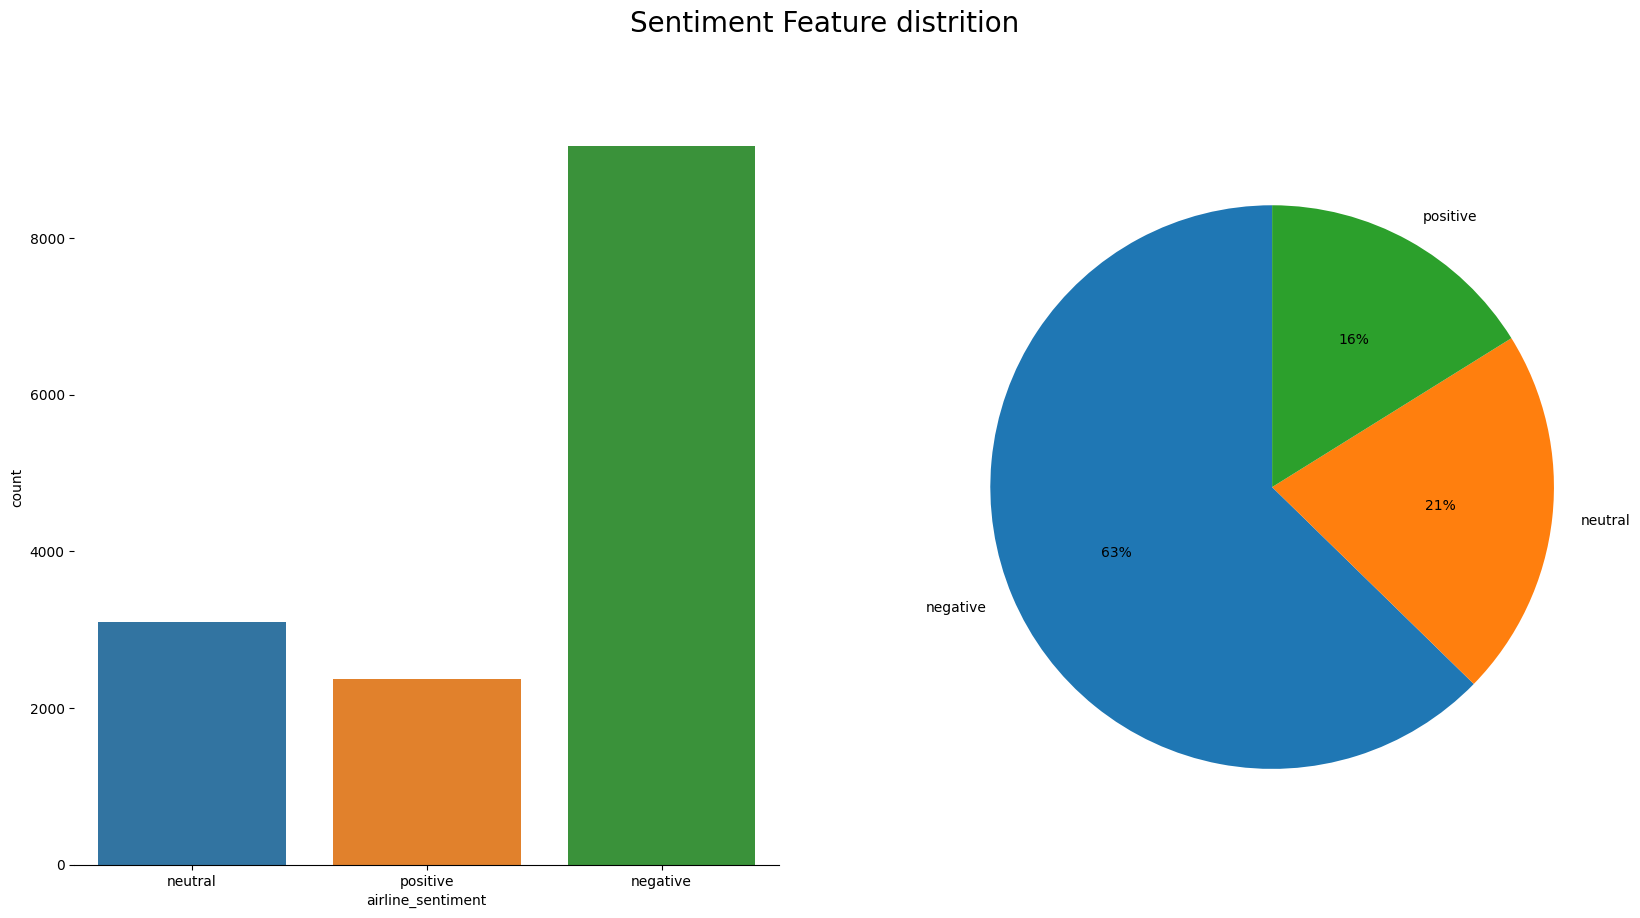

In [18]:
# Display
fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(20, 10), 
                         dpi=100)

sns.countplot(data['airline_sentiment'], ax=axes[0])

axes[1].pie(data['airline_sentiment'].value_counts(),
            labels= data['airline_sentiment'].value_counts().index,
            autopct='%1.0f%%',
            startangle=90)

fig.suptitle('Sentiment Feature distrition', fontsize=20)
plt.show()

the prevalent sentiment class among the airlines is mostly negative with the negative class accounting for 63% of the tweets

#### Airline sentiment confident interval distribution

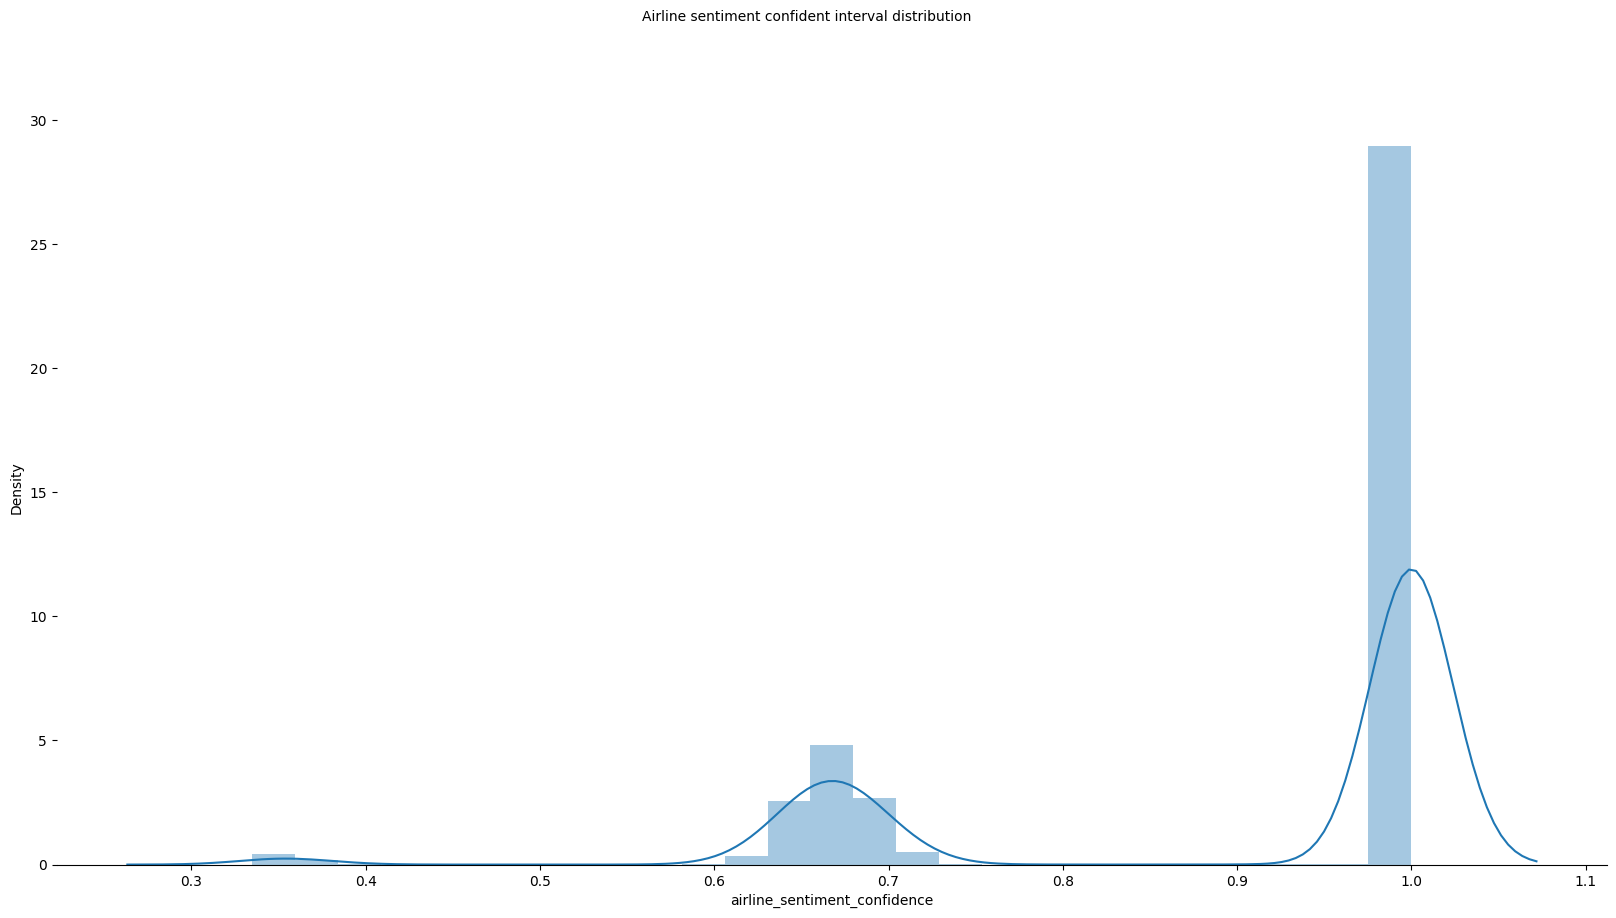

In [19]:
fig, axes = plt.subplots(figsize=(20, 10), 
                         dpi=100)
sns.distplot(data['airline_sentiment_confidence'],ax=axes)
fig.suptitle('Airline sentiment confident interval distribution', fontsize=10)
plt.ylabel("Density",fontsize=10)
#plt.xlabel('Time Progress',fontsize=10)
plt.show()

#### Negative reason Distribution

In [20]:
data['negativereason']=data['negativereason'].fillna('Unknown reason')

negative reason has missing values which will be categorised under unknown reason as there's no interpolation without context

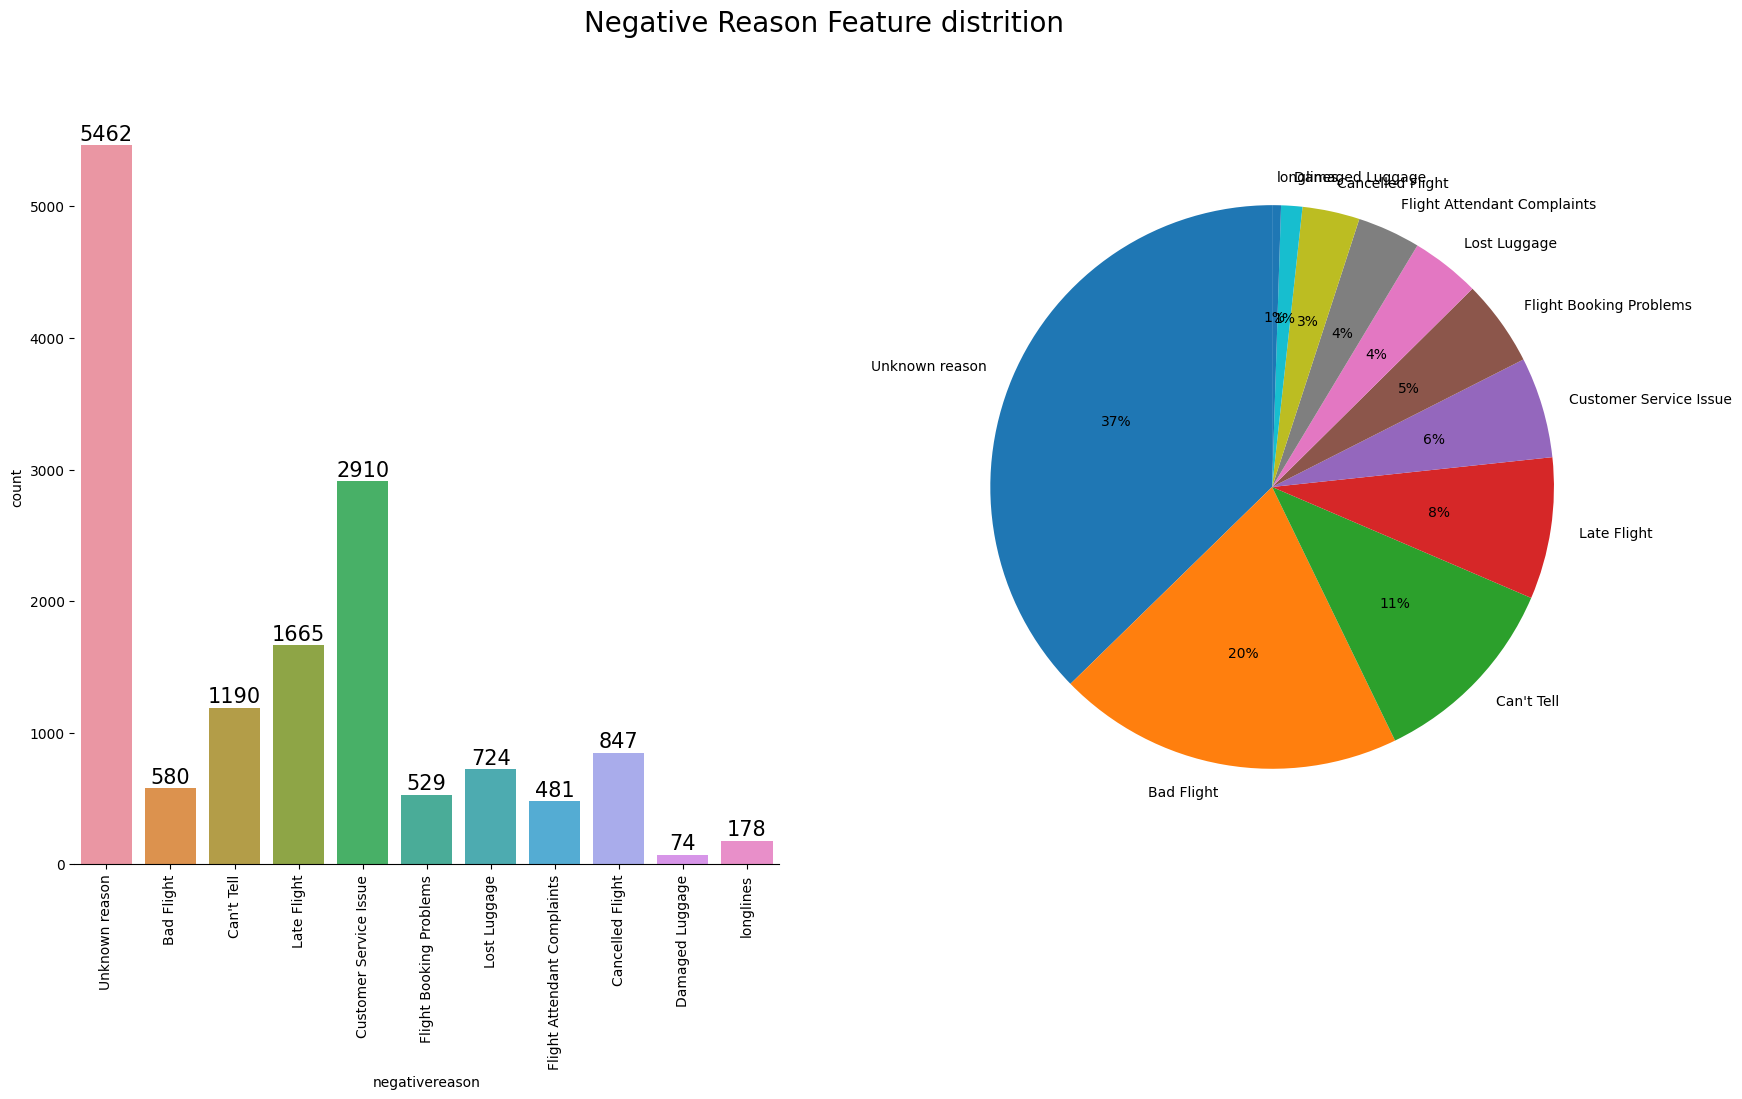

In [21]:
# Display
fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(20, 10), 
                         dpi=100)

plot=sns.countplot(data['negativereason'], ax=axes[0])
for bar in plot.patches:
    plot.annotate(round(bar.get_height()),(bar.get_x()+bar.get_width()/2,bar.get_height()), 
                  ha='center', va='center', size=15,xytext=(0,8),textcoords='offset points')
axes[0].set_xticklabels(labels=data['negativereason'].unique(),rotation = 90)

axes[1].pie(data['negativereason'].value_counts(),
            labels= data['negativereason'].unique(),
            autopct='%1.0f%%',
            startangle=90)
axes[1].set_xticklabels(labels=data['negativereason'].unique(),rotation = 90)

fig.suptitle('Negative Reason Feature distrition', fontsize=20)
plt.show()

The unknown reason accounts for the majority of the tweets

#### Negative reason confidence interval distribution

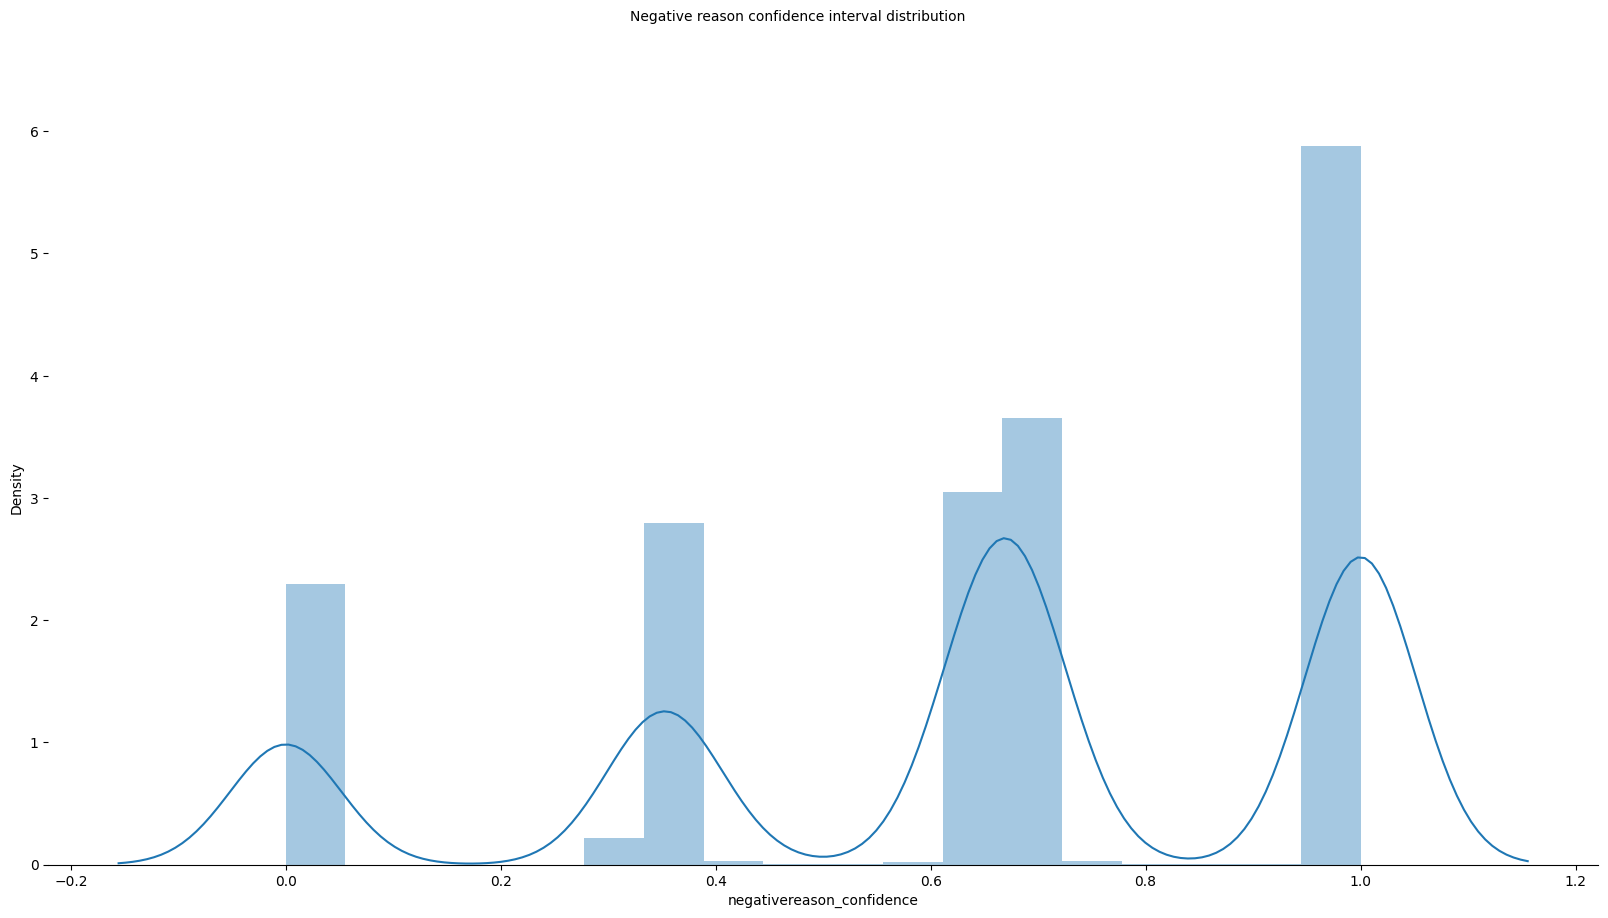

In [22]:
fig, axes = plt.subplots(figsize=(20, 10), 
                         dpi=100)
sns.distplot(data['negativereason_confidence'],ax=axes)
fig.suptitle('Negative reason confidence interval distribution', fontsize=10)
plt.ylabel("Density",fontsize=10)
#plt.xlabel('Time Progress',fontsize=10)
plt.show()

#### Airline distrition

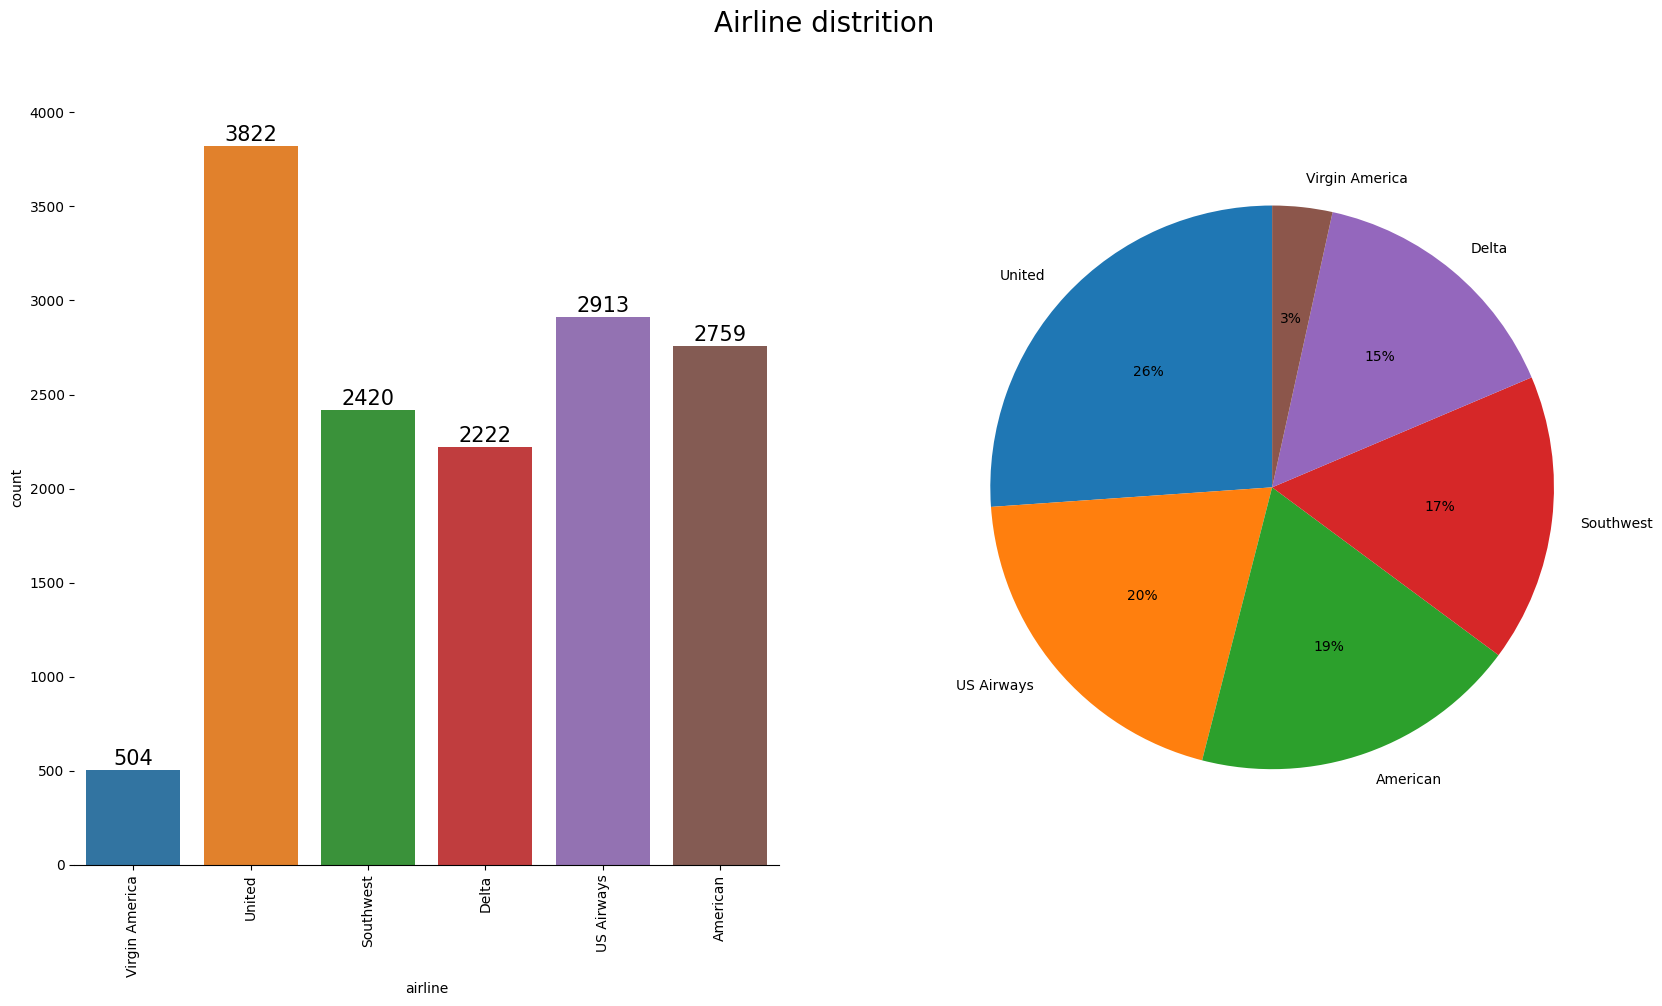

In [23]:
# Display
fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(20, 10), 
                         dpi=100)

plot=sns.countplot(data['airline'], ax=axes[0])
for bar in plot.patches:
    plot.annotate(round(bar.get_height()),(bar.get_x()+bar.get_width()/2,bar.get_height()), 
                  ha='center', va='center', size=15,xytext=(0,8),textcoords='offset points')
axes[0].set_xticklabels(labels=data['airline'].unique(),rotation = 90)

axes[1].pie(data['airline'].value_counts(),
            labels= data['airline'].value_counts().index,
            autopct='%1.0f%%',
            startangle=90)
axes[1].set_xticklabels(labels=data['airline'].unique(),rotation = 90)

fig.suptitle('Airline distrition', fontsize=20)
plt.show()

United airline is the most popular airline in our dataset

#### Retweet count distribution

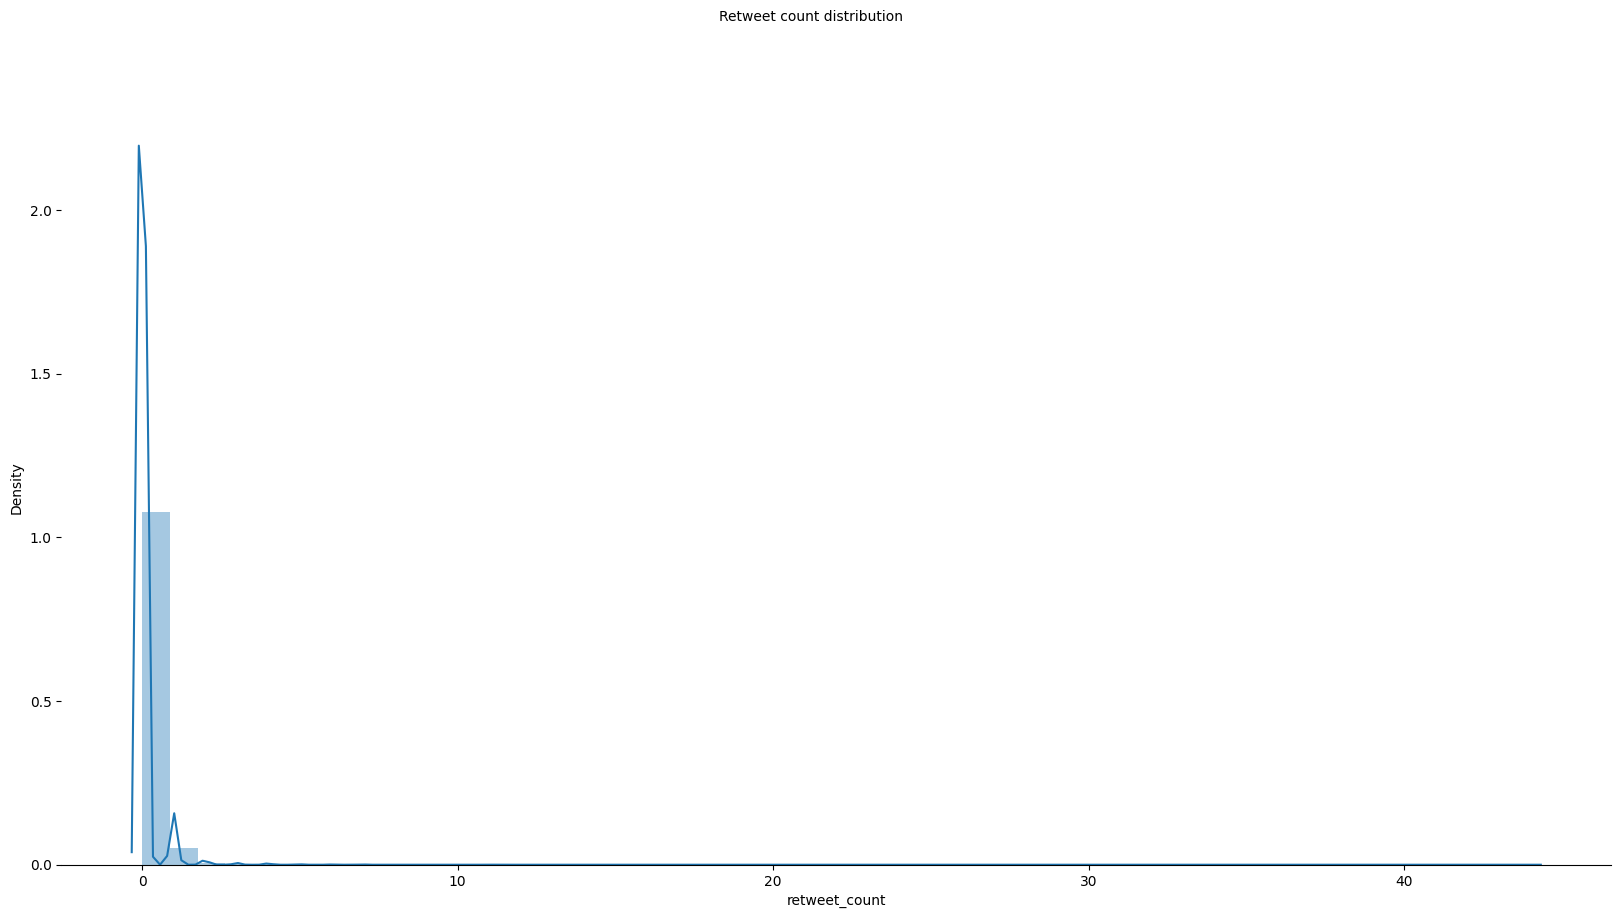

In [24]:
# retweet_count
fig, axes = plt.subplots(figsize=(20, 10), 
                         dpi=100)
sns.distplot(data['retweet_count'],ax=axes)
fig.suptitle('Retweet count distribution', fontsize=10)
plt.ylabel("Density",fontsize=10)
#plt.xlabel('Time Progress',fontsize=10)
plt.show()

the majority of the tweets do not have a retweet

### User time zone distribution

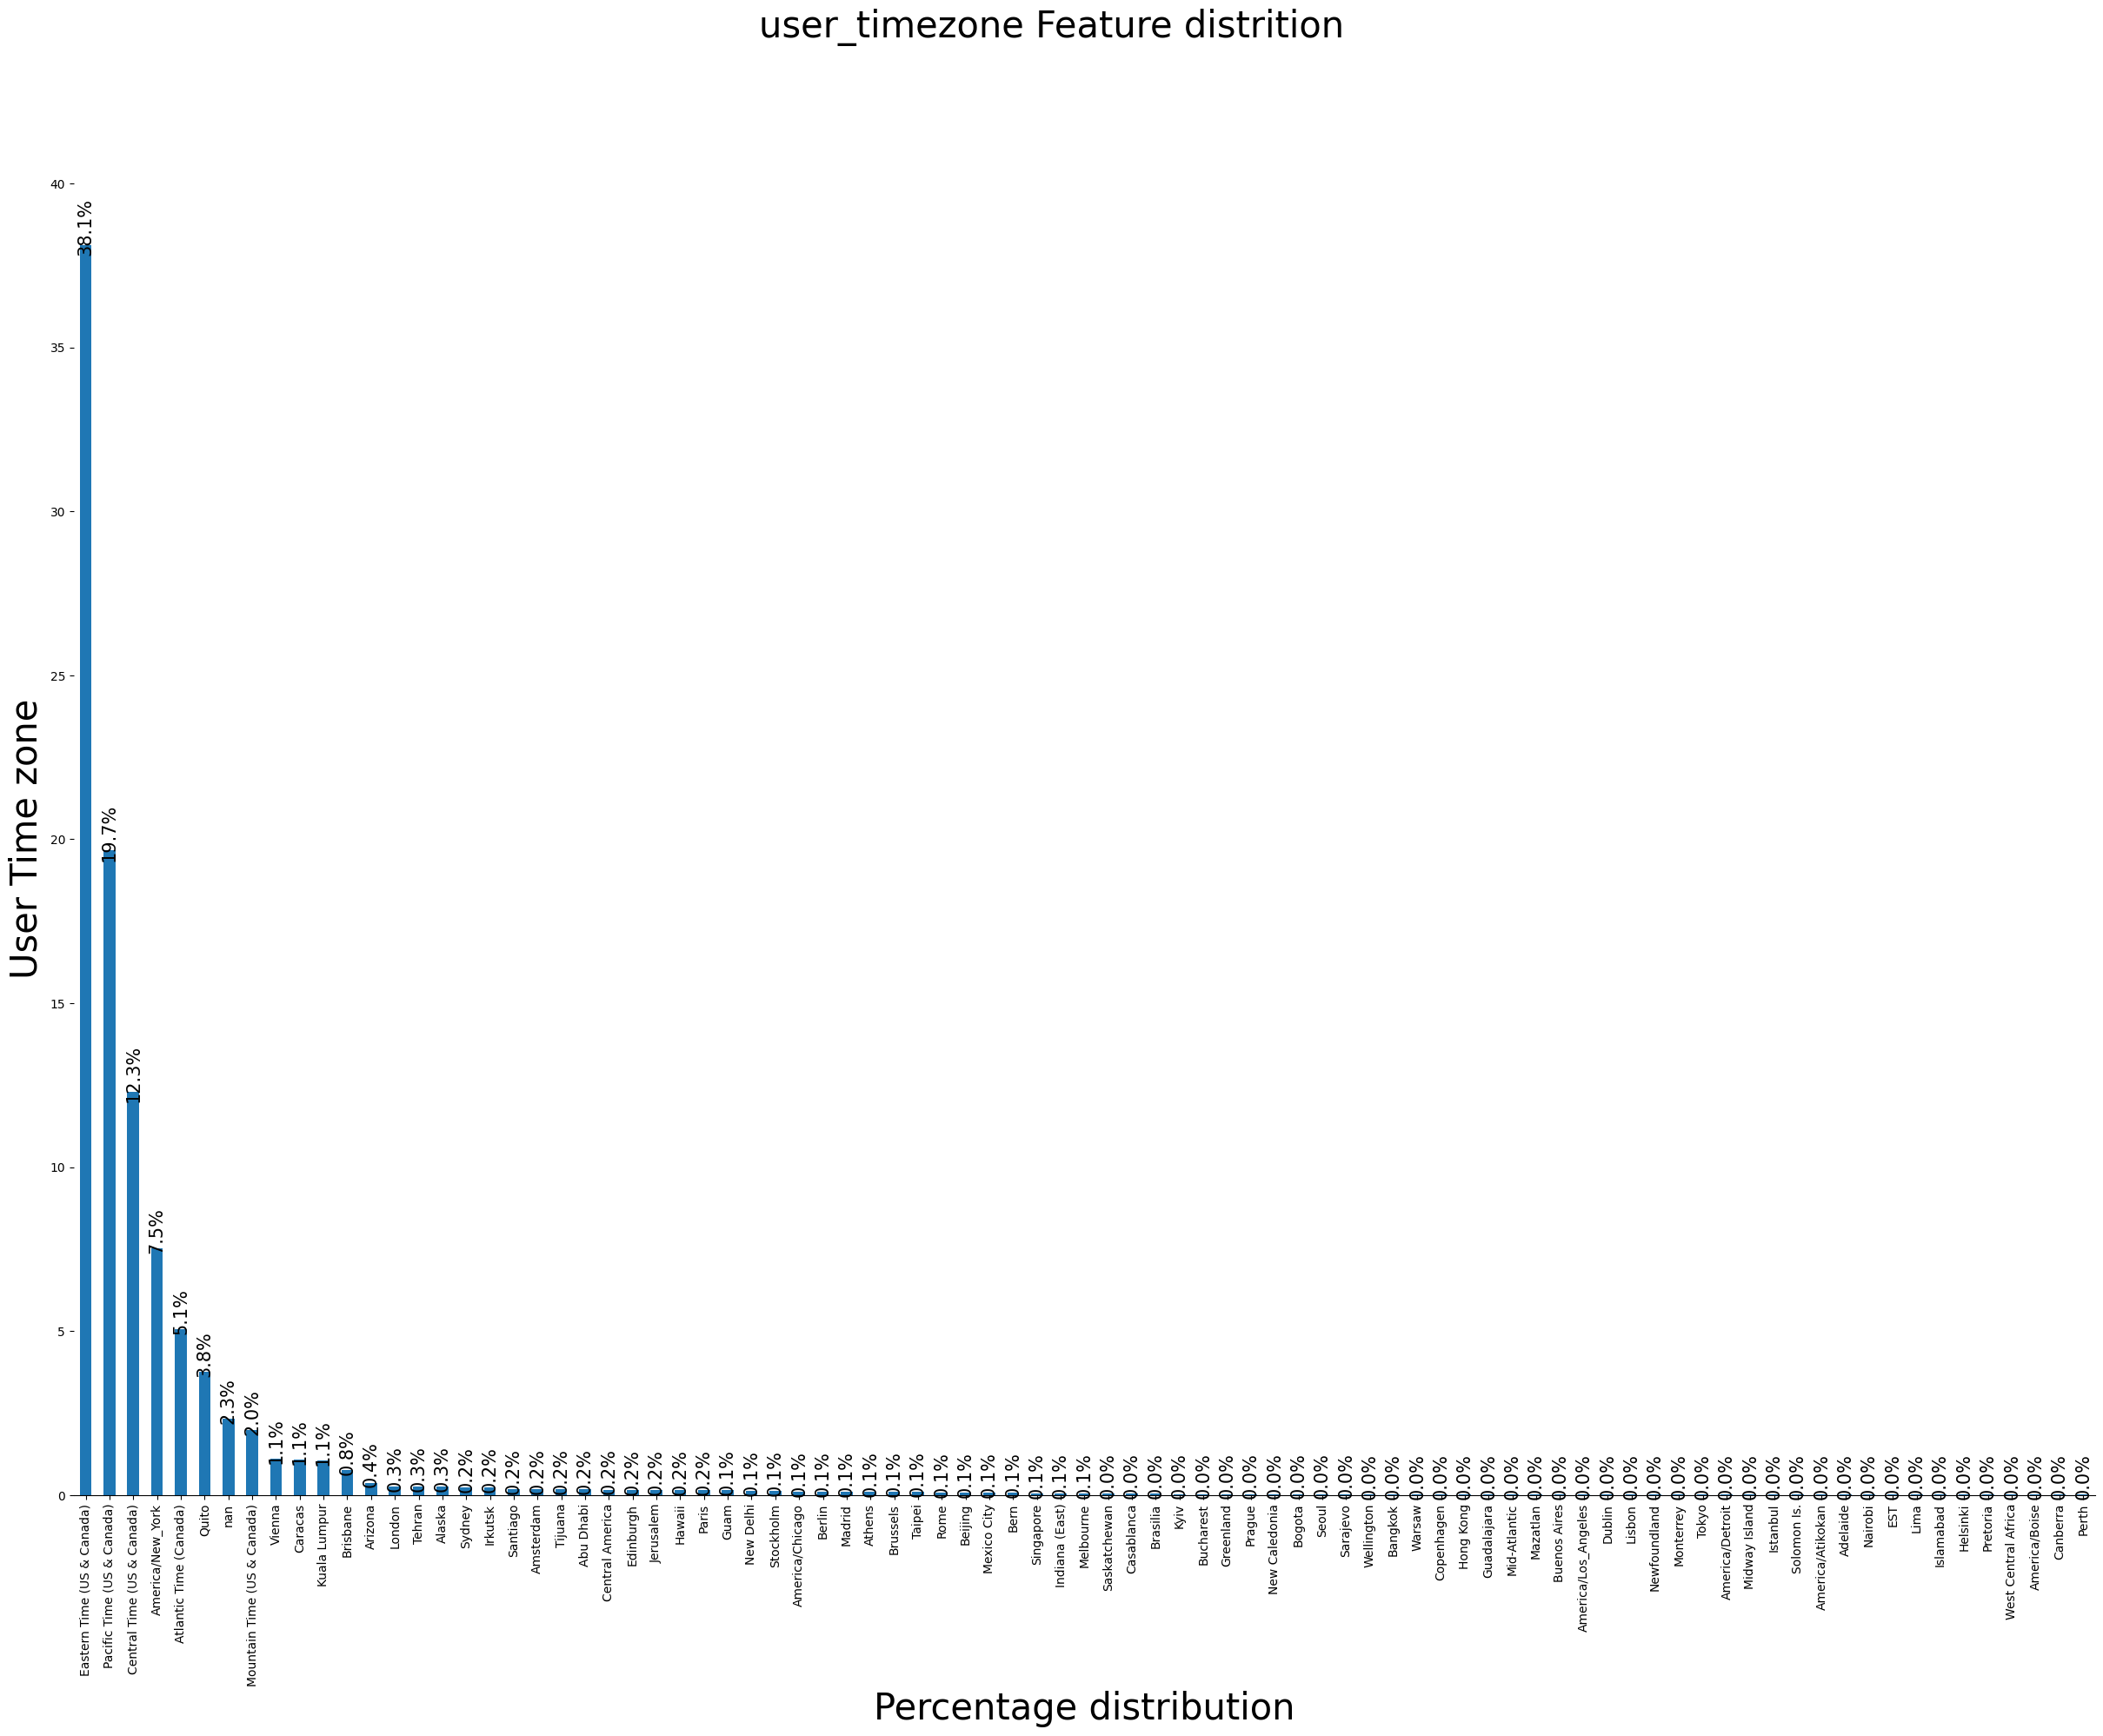

In [25]:
fig, axes = plt.subplots( figsize=(30, 20), dpi=100)

plot=(data['user_timezone'].value_counts(normalize=True)*100).plot(kind='bar')
for bar in plot.patches:
    if bar.get_height() == 0:
                pass
    else:
        plot.annotate(str(round(bar.get_height(),1))+'%',(bar.get_x()+bar.get_width()/2,bar.get_height()), 
                  ha='center', va='center', size=15,rotation=90,xytext=(0,15),textcoords='offset points')
        axes.set_xticklabels(labels=data['user_timezone'].unique(),rotation = 90)
fig.suptitle('user_timezone Feature distrition', fontsize=30)
plt.xlabel("Percentage distribution",fontsize=30)
plt.ylabel('User Time zone',fontsize=30)
plt.show()

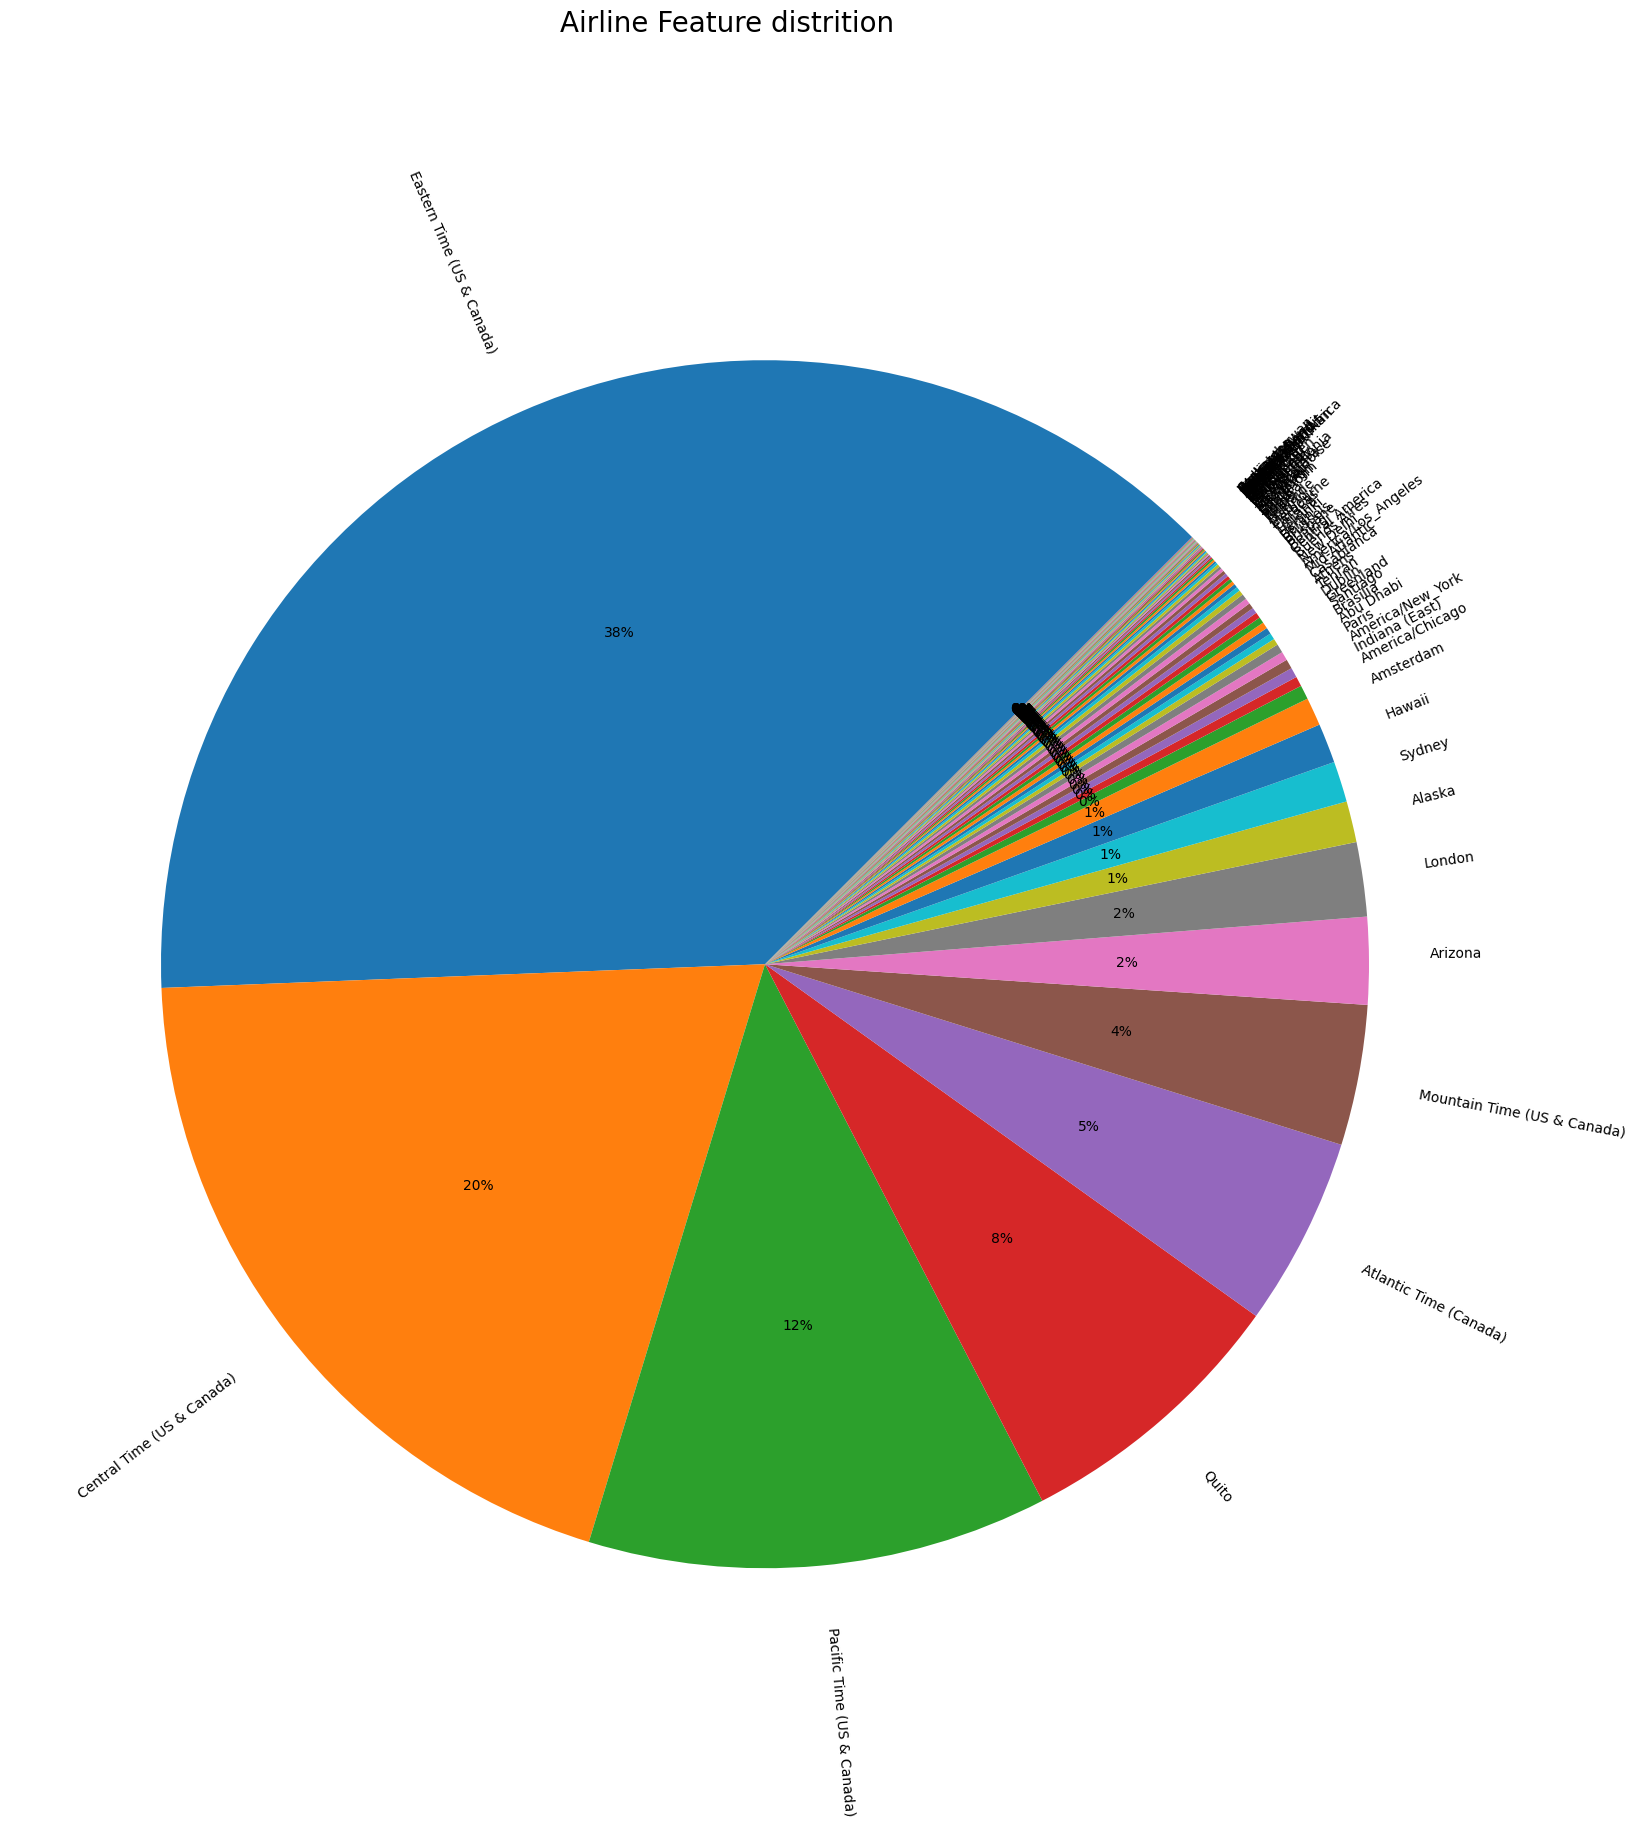

In [26]:
#tweet_location
# Display

fig, axes = plt.subplots( figsize=(30, 20), dpi=100)
axes.pie(data['user_timezone'].value_counts(),
            labels= data['user_timezone'].value_counts().index,
            autopct='%1.0f%%',rotatelabels=True,
            startangle=45)
axes.set_xticklabels(labels=data['user_timezone'].unique(),rotation = 90)

fig.suptitle('Airline Feature distrition', fontsize=20)
plt.show()

majority of the tweets are within the Eastern Time (US & CANADA)

#### data cleaning

In [27]:
def mentions(x):
    x = re.sub(r"(?:\@|https?\://)\S+", "", x)
    return x

def remove_punc(x):
    x = re.sub(r"([^A-Za-z0-9]+)"," ",x)
    return x

def StopWords():
    stop_words = set(stopwords.words('english'))
    return stop_words

def word_count(train):
    cnt = Counter()
    for message in train['message'].values:
        for word in message:
            cnt[word] +=1
    return cnt.most_common(20)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

In [30]:
def data_cleaning(df):
    retweet = 'RT'
    wnl = WordNetLemmatizer()
    df['message'] = df['text'].apply(mentions)
    #df['message'] = df['message'].apply(lambda x: contractions.fix(x))
    df['message'] = df['message'].str.replace(r"http\S+|www.\S+", "", case=False)
    df['message'] = df['message'].map(lambda x: remove_punc(str(x)))
    df['message'] = df['message'].apply(word_tokenize)
    df['message'] = df['message'].apply(lambda x: [word for word in x if word not in retweet])
    df['message'] = df['message'].apply(lambda x : [word.lower() for word in x])
    df['message'] = df['message'].apply(lambda x: [word for word in x if word not in StopWords()])
    df['pos_tags'] = df['message'].apply(nltk.tag.pos_tag)
    df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['message'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
    return df
df=data_cleaning(data)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,message,pos_tags,wordnet_pos
0,570306133677760513,neutral,1.0000,Unknown reason,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),[say],"[(said, VBD)]","[(said, v)]"
1,570301130888122368,positive,0.3486,Unknown reason,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),"[plus, added, commercial, experience, tacky]","[(plus, CC), (added, JJ), (commercials, NNS), ...","[(plus, n), (added, a), (commercials, n), (exp..."
2,570301083672813571,neutral,0.6837,Unknown reason,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),"[today, must, mean, need, take, another, trip]","[(today, NN), (must, MD), (mean, VB), (need, M...","[(today, n), (must, n), (mean, v), (need, n), ..."
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"[really, aggressive, blast, obnoxious, enterta...","[(really, RB), (aggressive, JJ), (blast, NN), ...","[(really, r), (aggressive, a), (blast, n), (ob..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),"[really, big, bad, thing]","[(really, RB), (big, JJ), (bad, JJ), (thing, NN)]","[(really, r), (big, a), (bad, a), (thing, n)]"


#### Most frequent words by sentiment class

In [31]:
def wordcloud_visualizer(df):
    neutral = df['message'][df['airline_sentiment']=='neutral'].str.join(' ')
    pro = df['message'][df['airline_sentiment']=='positive'].str.join(' ')
    anti = df['message'][df['airline_sentiment']=='negative'].str.join(' ')
    #Visualize each sentiment class
    fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
    neutral_wordcloud = WordCloud(width=900, height=900, background_color='white', colormap='winter', min_font_size=10).generate(str(neutral))
    axis[1].imshow(neutral_wordcloud)
    axis[1].set_title('Neutral Airline sentiment',fontsize=14)
    axis[1].axis("off") 
    
    pro_wordcloud = WordCloud(width=900, height=900, background_color='white', colormap='Greens', min_font_size=10).generate(str(pro))
    axis[2].imshow(pro_wordcloud)
    axis[2].set_title('Positive Airline sentiment',fontsize=14)
    axis[2].axis("off") 
    anti_wordcloud = WordCloud(width=900, height=900, background_color='white', colormap='Reds', min_font_size=10).generate(str(anti))
    axis[0].imshow(anti_wordcloud)
    axis[0].set_title('Negative Airline Sentiment',fontsize=14)
    axis[0].axis("off")


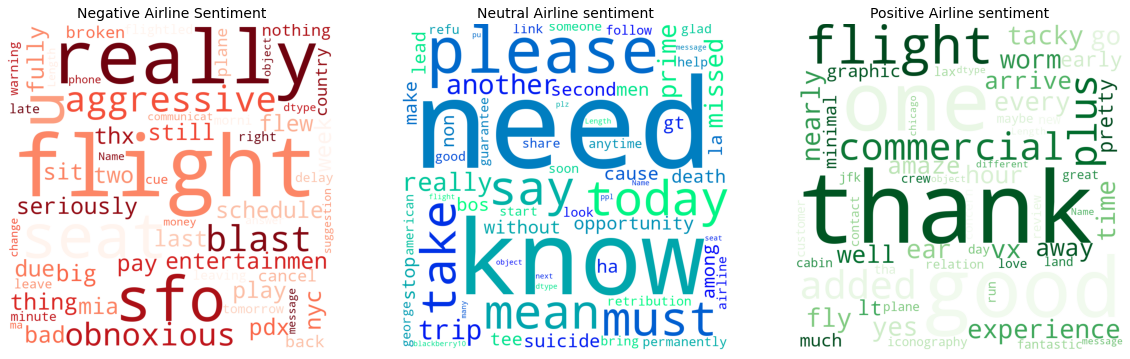

In [32]:
wordcloud_visualizer(data)

### Feature engineering

In [33]:
data['final_tweet']=data['message'].str.join(' ')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,message,pos_tags,wordnet_pos,final_tweet
0,570306133677760513,neutral,1.0000,Unknown reason,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),[say],"[(said, VBD)]","[(said, v)]",say
1,570301130888122368,positive,0.3486,Unknown reason,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),"[plus, added, commercial, experience, tacky]","[(plus, CC), (added, JJ), (commercials, NNS), ...","[(plus, n), (added, a), (commercials, n), (exp...",plus added commercial experience tacky
2,570301083672813571,neutral,0.6837,Unknown reason,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),"[today, must, mean, need, take, another, trip]","[(today, NN), (must, MD), (mean, VB), (need, M...","[(today, n), (must, n), (mean, v), (need, n), ...",today must mean need take another trip
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"[really, aggressive, blast, obnoxious, enterta...","[(really, RB), (aggressive, JJ), (blast, NN), ...","[(really, r), (aggressive, a), (blast, n), (ob...",really aggressive blast obnoxious entertainmen...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),"[really, big, bad, thing]","[(really, RB), (big, JJ), (bad, JJ), (thing, NN)]","[(really, r), (big, a), (bad, a), (thing, n)]",really big bad thing


In [34]:
data['length']=data['text'].apply(lambda c: len(c))
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,message,pos_tags,wordnet_pos,final_tweet,length
0,570306133677760513,neutral,1.0000,Unknown reason,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),[say],"[(said, VBD)]","[(said, v)]",say,35
1,570301130888122368,positive,0.3486,Unknown reason,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),"[plus, added, commercial, experience, tacky]","[(plus, CC), (added, JJ), (commercials, NNS), ...","[(plus, n), (added, a), (commercials, n), (exp...",plus added commercial experience tacky,72
2,570301083672813571,neutral,0.6837,Unknown reason,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),"[today, must, mean, need, take, another, trip]","[(today, NN), (must, MD), (mean, VB), (need, M...","[(today, n), (must, n), (mean, v), (need, n), ...",today must mean need take another trip,71
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"[really, aggressive, blast, obnoxious, enterta...","[(really, RB), (aggressive, JJ), (blast, NN), ...","[(really, r), (aggressive, a), (blast, n), (ob...",really aggressive blast obnoxious entertainmen...,126
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),"[really, big, bad, thing]","[(really, RB), (big, JJ), (bad, JJ), (thing, NN)]","[(really, r), (big, a), (bad, a), (thing, n)]",really big bad thing,55


In [35]:
data['tweet_date']=pd.to_datetime(data['tweet_created']).dt.date

#### Tweet leangth over time

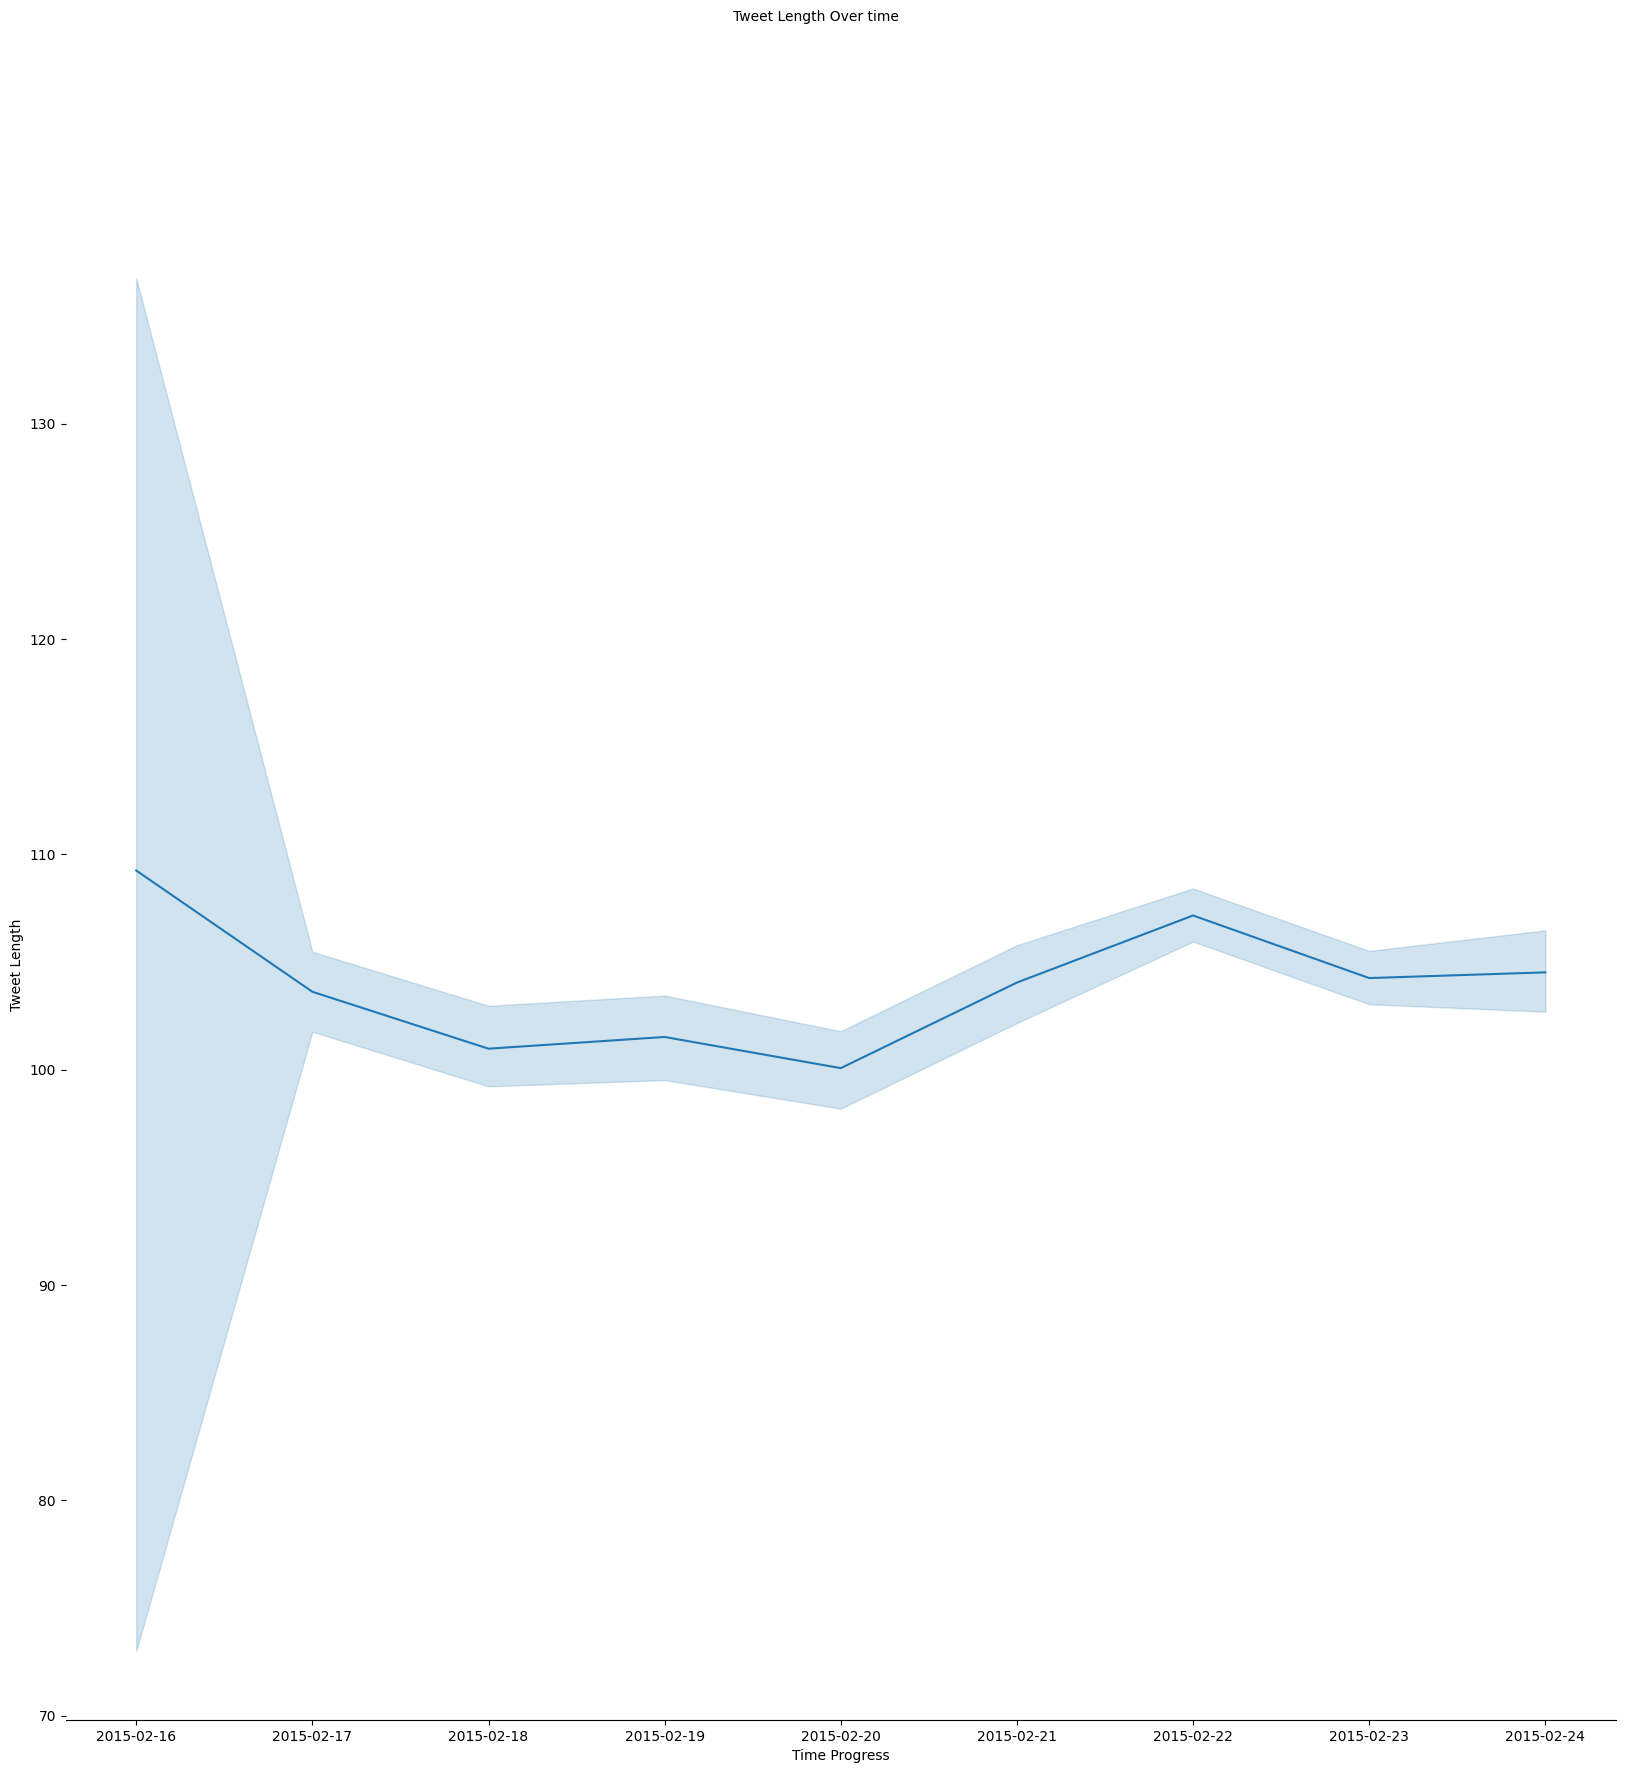

In [36]:
# Plot the responses for different events and regions
fig, axes = plt.subplots(figsize=(20, 20), dpi=100)
sns.lineplot(x="tweet_date", y="length",ax=axes,data=data)
fig.suptitle('Tweet Length Over time', fontsize=10)
plt.ylabel("Tweet Length",fontsize=10)
plt.xlabel('Time Progress',fontsize=10)
plt.show()

#### Tweet length over by sentiment class

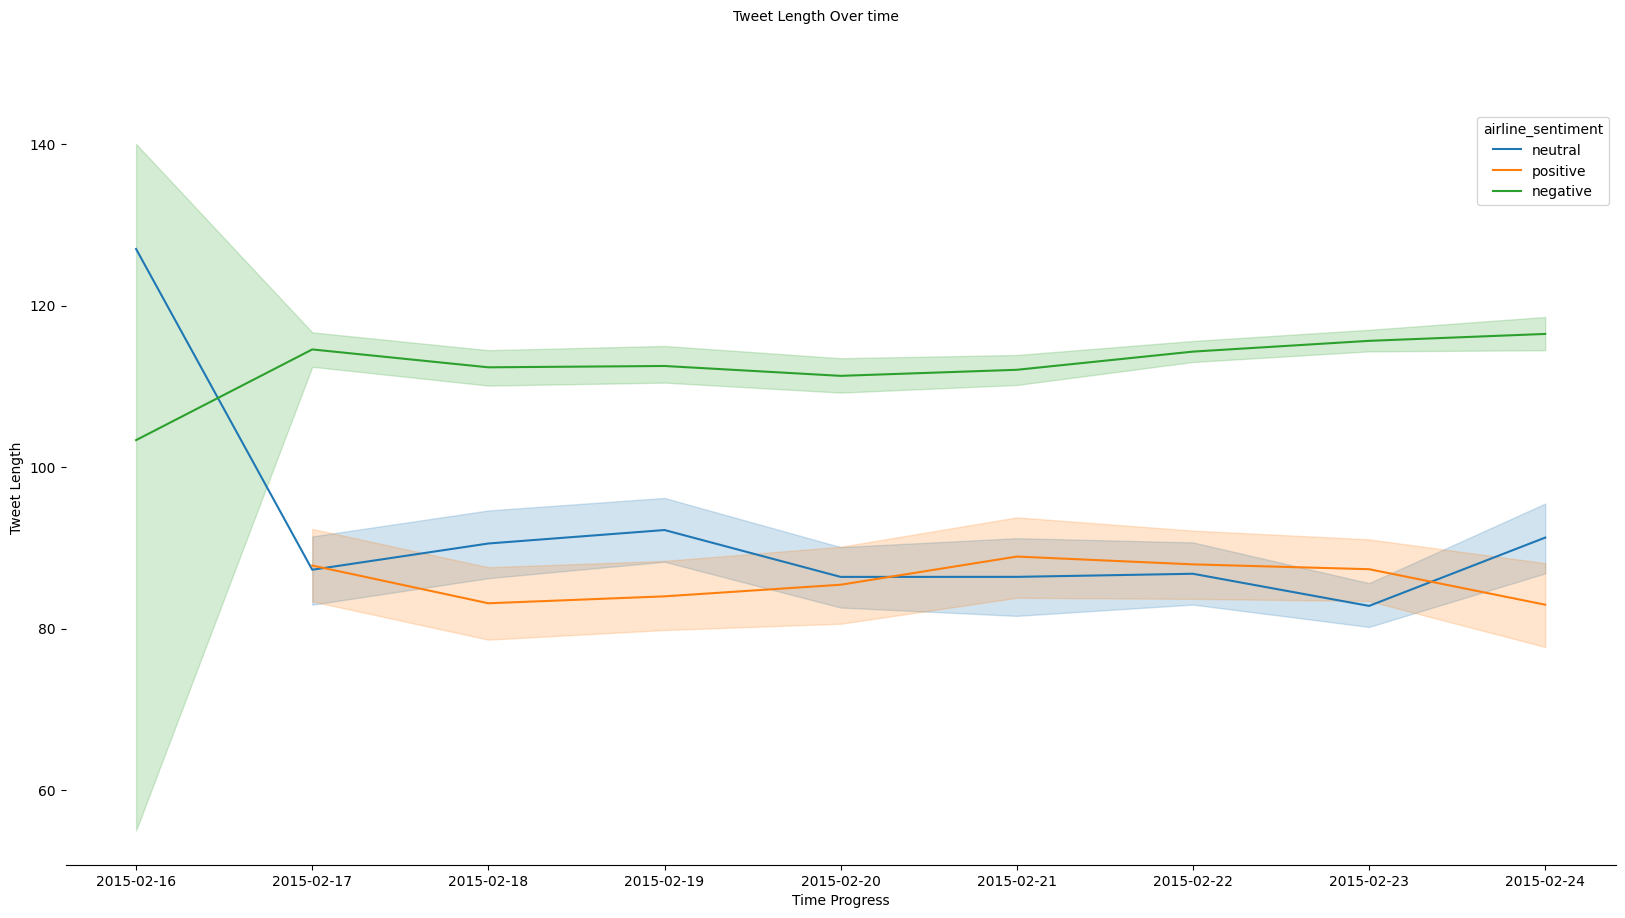

In [37]:
#sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
fig, axes = plt.subplots(figsize=(20, 10), dpi=100)
sns.lineplot(x="tweet_date", y="length",
             hue="airline_sentiment",ax=axes,
             data=data)
fig.suptitle('Tweet Length Over time', fontsize=10)
plt.ylabel("Tweet Length",fontsize=10)
plt.xlabel('Time Progress',fontsize=10)
plt.show()

### Text Polarity aka Sentiment analysis
Sentiment analysis is a technique that detects the underlying sentiment in a piece of text. It is the process of classifying text as either positive, negative, or neutral. The values range from 1 to -1; with positivity decreasing from 1 to -1, having a neutral sentiment at 0.

In [38]:
from textblob import TextBlob

In [39]:
data['polarity']=data['final_tweet'].apply(lambda x:TextBlob(x).sentiment.polarity)

#### Tweet sentiment over time

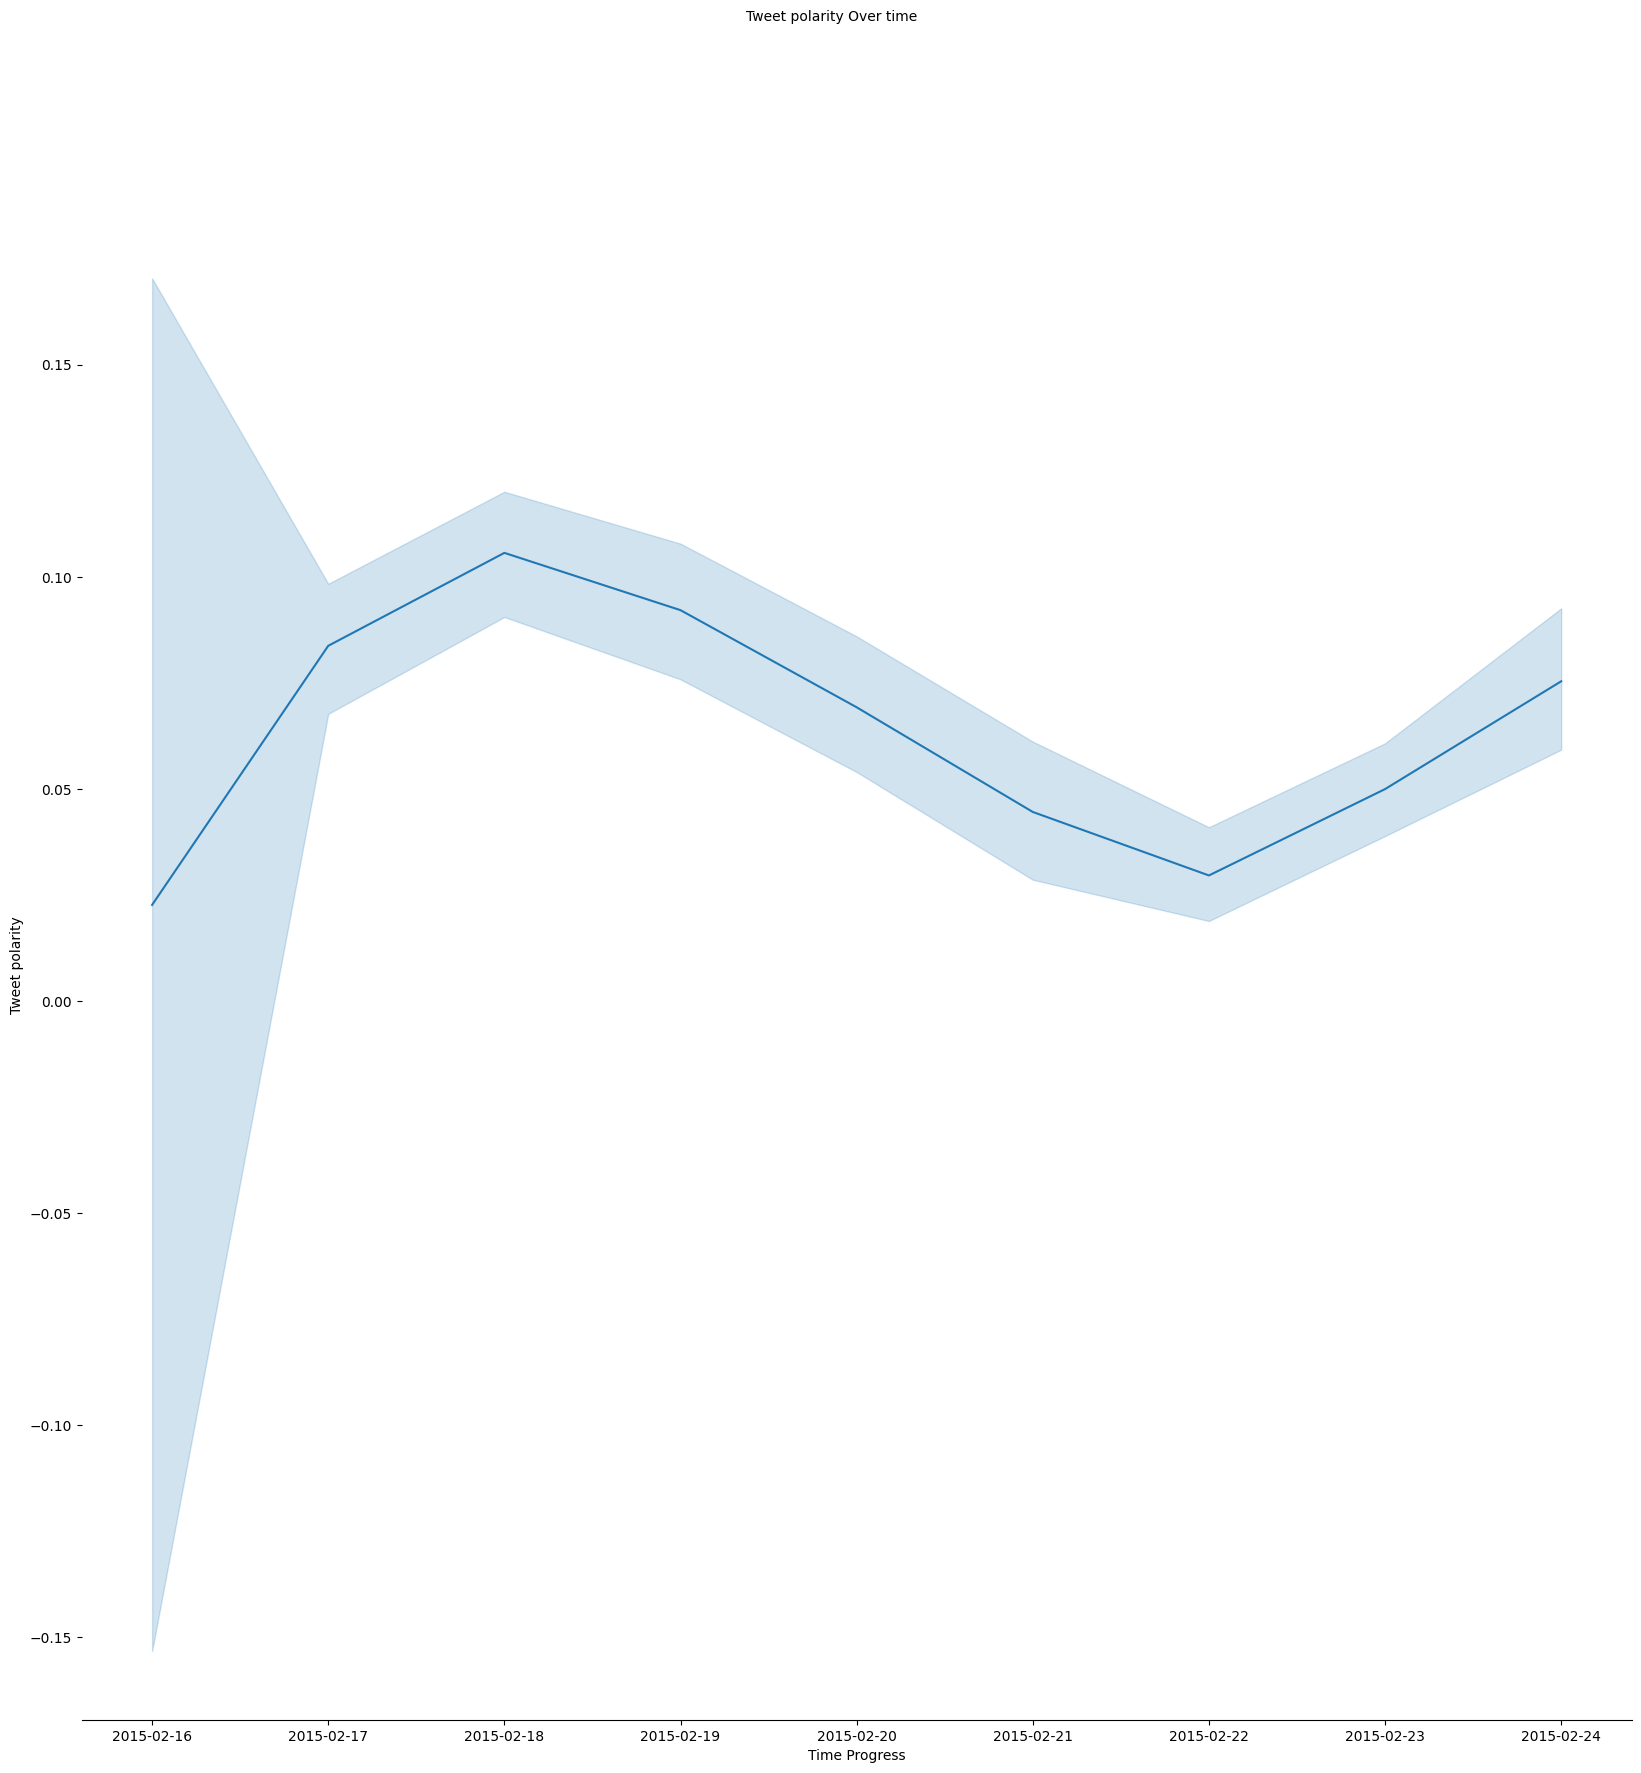

In [40]:
fig, axes = plt.subplots(figsize=(20, 20), dpi=100)
sns.lineplot(x="tweet_date", y="polarity",ax=axes,data=data)
fig.suptitle('Tweet polarity Over time', fontsize=10)
plt.ylabel("Tweet polarity",fontsize=10)
plt.xlabel('Time Progress',fontsize=10)
plt.show()

#### Tweent sentiment over time by sentiment class

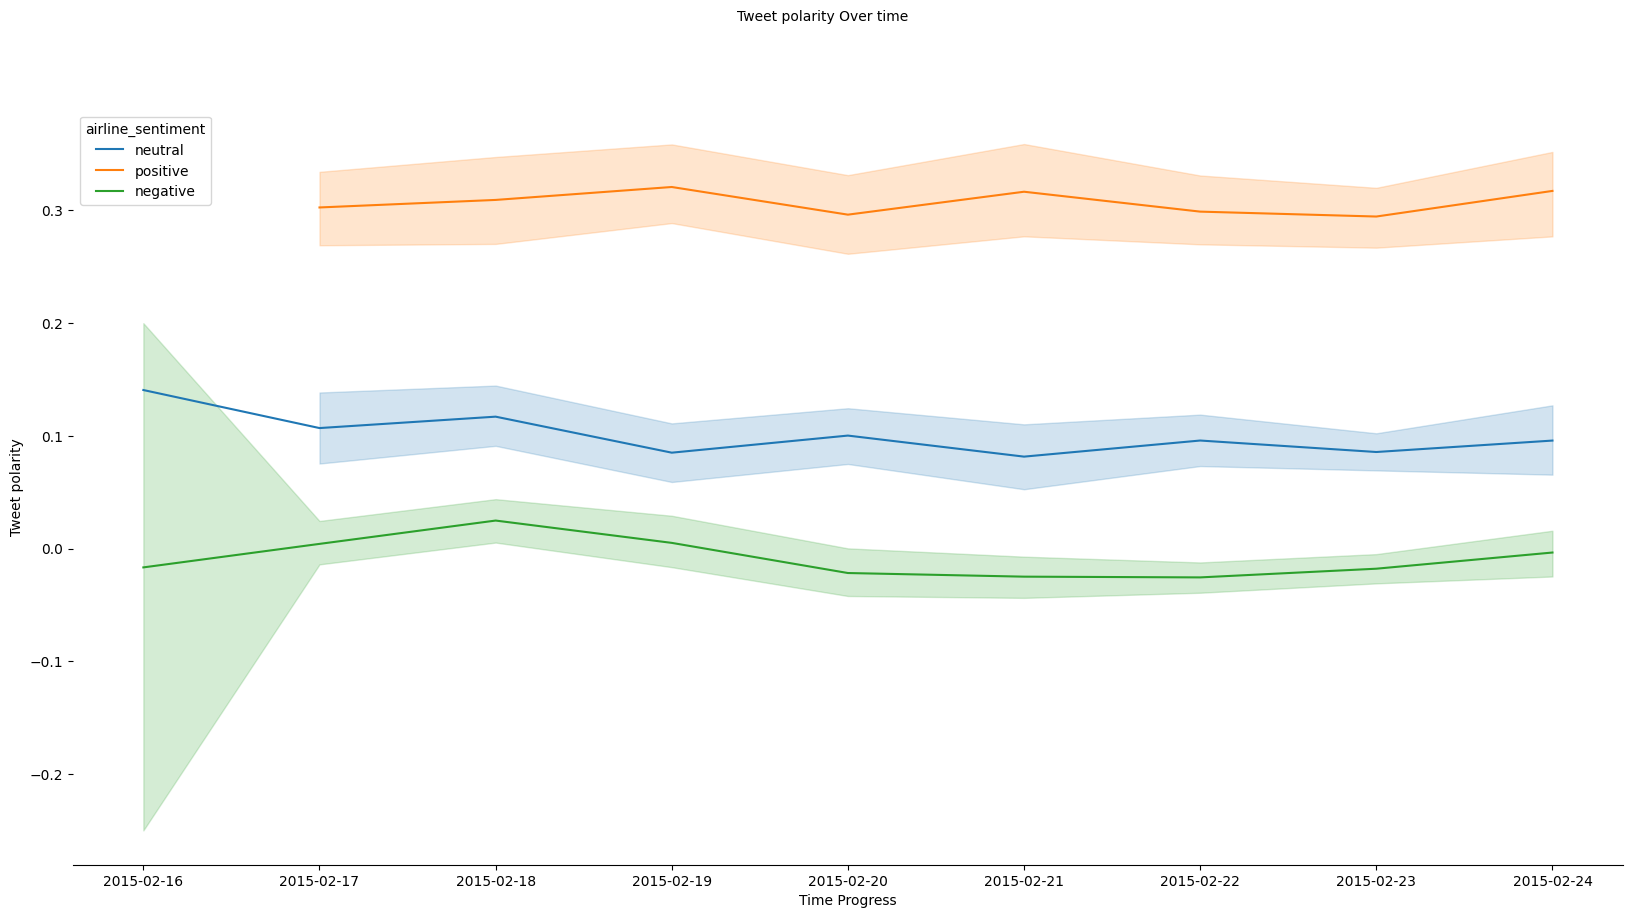

In [41]:
fig, axes = plt.subplots(figsize=(20, 10), dpi=100)
sns.lineplot(x="tweet_date", y="polarity",hue='airline_sentiment',ax=axes,data=data)
fig.suptitle('Tweet polarity Over time', fontsize=10)
plt.ylabel("Tweet polarity",fontsize=10)
plt.xlabel('Time Progress',fontsize=10)
plt.show()

### Modelling 

In [42]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,message,pos_tags,wordnet_pos,final_tweet,length,tweet_date,polarity
0,570306133677760513,neutral,1.0000,Unknown reason,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),[say],"[(said, VBD)]","[(said, v)]",say,35,2015-02-24,0.00000
1,570301130888122368,positive,0.3486,Unknown reason,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),"[plus, added, commercial, experience, tacky]","[(plus, CC), (added, JJ), (commercials, NNS), ...","[(plus, n), (added, a), (commercials, n), (exp...",plus added commercial experience tacky,72,2015-02-24,0.00000
2,570301083672813571,neutral,0.6837,Unknown reason,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),"[today, must, mean, need, take, another, trip]","[(today, NN), (must, MD), (mean, VB), (need, M...","[(today, n), (must, n), (mean, v), (need, n), ...",today must mean need take another trip,71,2015-02-24,-0.31250
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"[really, aggressive, blast, obnoxious, enterta...","[(really, RB), (aggressive, JJ), (blast, NN), ...","[(really, r), (aggressive, a), (blast, n), (ob...",really aggressive blast obnoxious entertainmen...,126,2015-02-24,0.00625
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),"[really, big, bad, thing]","[(really, RB), (big, JJ), (bad, JJ), (thing, NN)]","[(really, r), (big, a), (bad, a), (thing, n)]",really big bad thing,55,2015-02-24,-0.35000


In [43]:
df=data[['airline_sentiment_confidence','negativereason','negativereason_confidence','airline','retweet_count','user_timezone','tweet_date','polarity']]
df.head()

,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,user_timezone,tweet_date,polarity
0,1.0000,Unknown reason,NaN,Virgin America,0,Eastern Time (US & Canada),2015-02-24,0.00000
1,0.3486,Unknown reason,0.0000,Virgin America,0,Pacific Time (US & Canada),2015-02-24,0.00000
2,0.6837,Unknown reason,NaN,Virgin America,0,Central Time (US & Canada),2015-02-24,-0.31250
3,1.0000,Bad Flight,0.7033,Virgin America,0,Pacific Time (US & Canada),2015-02-24,0.00625
4,1.0000,Can't Tell,1.0000,Virgin America,0,Pacific Time (US & Canada),2015-02-24,-0.35000


In [44]:
df.isna().sum()

airline_sentiment_confidence       0
negativereason                     0
negativereason_confidence       4118
airline                            0
retweet_count                      0
user_timezone                   4820
tweet_date                         0
polarity                           0
dtype: int64

In [45]:
df['negativereason_confidence']=df['negativereason_confidence'].interpolate()

In [46]:
df['user_timezone']=df['user_timezone'].fillna('Unknown Time zone')

In [47]:
df.head()

,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,user_timezone,tweet_date,polarity
0,1.0000,Unknown reason,NaN,Virgin America,0,Eastern Time (US & Canada),2015-02-24,0.00000
1,0.3486,Unknown reason,0.00000,Virgin America,0,Pacific Time (US & Canada),2015-02-24,0.00000
2,0.6837,Unknown reason,0.35165,Virgin America,0,Central Time (US & Canada),2015-02-24,-0.31250
3,1.0000,Bad Flight,0.70330,Virgin America,0,Pacific Time (US & Canada),2015-02-24,0.00625
4,1.0000,Can't Tell,1.00000,Virgin America,0,Pacific Time (US & Canada),2015-02-24,-0.35000


In [48]:
#output=pd.get_dummies(df,df[['negativereason','airline','user_timezone']],drop_first=True)
#output.head()
result =pd.get_dummies(df, columns = ['negativereason','airline','user_timezone'])

In [49]:
result.head()

,airline_sentiment_confidence,negativereason_confidence,retweet_count,tweet_date,polarity,negativereason_Bad Flight,negativereason_Can't Tell,negativereason_Cancelled Flight,negativereason_Customer Service Issue,negativereason_Damaged Luggage,negativereason_Flight Attendant Complaints,negativereason_Flight Booking Problems,negativereason_Late Flight,negativereason_Lost Luggage,negativereason_Unknown reason,negativereason_longlines,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America,user_timezone_Abu Dhabi,user_timezone_Adelaide,user_timezone_Alaska,user_timezone_America/Atikokan,user_timezone_America/Boise,user_timezone_America/Chicago,user_timezone_America/Detroit,user_timezone_America/Los_Angeles,user_timezone_America/New_York,user_timezone_Amsterdam,user_timezone_Arizona,user_timezone_Athens,user_timezone_Atlantic Time (Canada),user_timezone_Bangkok,user_timezone_Beijing,user_timezone_Berlin,user_timezone_Bern,user_timezone_Bogota,user_timezone_Brasilia,user_timezone_Brisbane,user_timezone_Brussels,user_timezone_Bucharest,user_timezone_Buenos Aires,user_timezone_Canberra,user_timezone_Caracas,user_timezone_Casablanca,user_timezone_Central America,user_timezone_Central Time (US & Canada),user_timezone_Copenhagen,user_timezone_Dublin,user_timezone_EST,user_timezone_Eastern Time (US & Canada),user_timezone_Edinburgh,user_timezone_Greenland,user_timezone_Guadalajara,user_timezone_Guam,user_timezone_Hawaii,user_timezone_Helsinki,user_timezone_Hong Kong,user_timezone_Indiana (East),user_timezone_Irkutsk,user_timezone_Islamabad,user_timezone_Istanbul,user_timezone_Jerusalem,user_timezone_Kuala Lumpur,user_timezone_Kyiv,user_timezone_La Paz,user_timezone_Lima,user_timezone_Lisbon,user_timezone_London,user_timezone_Madrid,user_timezone_Mazatlan,user_timezone_Melbourne,user_timezone_Mexico City,user_timezone_Mid-Atlantic,user_timezone_Midway Island,user_timezone_Monterrey,user_timezone_Mountain Time (US & Canada),user_timezone_Nairobi,user_timezone_New Caledonia,user_timezone_New Delhi,user_timezone_Newfoundland,user_timezone_Pacific Time (US & Canada),user_timezone_Paris,user_timezone_Perth,user_timezone_Prague,user_timezone_Pretoria,user_timezone_Quito,user_timezone_Rome,user_timezone_Santiago,user_timezone_Sarajevo,user_timezone_Saskatchewan,user_timezone_Seoul,user_timezone_Singapore,user_timezone_Solomon Is.,user_timezone_Stockholm,user_timezone_Sydney,user_timezone_Taipei,user_timezone_Tehran,user_timezone_Tijuana,user_timezone_Tokyo,user_timezone_Unknown Time zone,user_timezone_Vienna,user_timezone_Warsaw,user_timezone_Wellington,user_timezone_West Central Africa
0,1.0000,NaN,0,2015-02-24,0.00000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.3486,0.00000,0,2015-02-24,0.00000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.6837,0.35165,0,2015-02-24,-0.31250,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0000,0.70330,0,2015-02-24,0.00625,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0000,1.00000,0,2015-02-24,-0.35000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


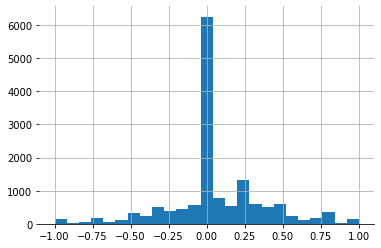

In [54]:
result.polarity.hist(bins=25)

In [76]:
y=result['polarity']
X=result.drop('polarity',axis=1)

I had problems with the pymc Modelling part as it keeps on giving errors and being buggy but installation on google colab works fine